In [1]:
import pandas as pd
import numpy as np
import matplotlib as plt
%pylab inline

Populating the interactive namespace from numpy and matplotlib


/root/miniconda3/lib/python3.6/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['plt']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [2]:
import torch
from torch import nn
from torch.utils.data import TensorDataset, DataLoader

In [3]:
from networks import IMVTensorLSTM

In [4]:
data1 = pd.read_csv("../from_dgx/TS_datasets/sml2010/NEW-DATA-1.T15.txt", sep=' ')
data2 = pd.read_csv("../from_dgx/TS_datasets/sml2010/NEW-DATA-2.T15.txt", sep=' ')

In [5]:
target = '3:Temperature_Comedor_Sensor'
cols = [
    '3:Temperature_Comedor_Sensor',
 '4:Temperature_Habitacion_Sensor',
 '5:Weather_Temperature',
 '6:CO2_Comedor_Sensor',
 '7:CO2_Habitacion_Sensor',
 '8:Humedad_Comedor_Sensor',
 '9:Humedad_Habitacion_Sensor',
 '10:Lighting_Comedor_Sensor',
 '11:Lighting_Habitacion_Sensor',
 '12:Precipitacion',
 '13:Meteo_Exterior_Crepusculo',
 '14:Meteo_Exterior_Viento',
 '15:Meteo_Exterior_Sol_Oest',
 '16:Meteo_Exterior_Sol_Est',
 '20:Exterior_Entalpic_2',
 '21:Exterior_Entalpic_turbo',
 '22:Temperature_Exterior_Sensor']

In [6]:
data1.head()

,#,Unnamed: 1,1:Date,2:Time,3:Temperature_Comedor_Sensor,4:Temperature_Habitacion_Sensor,5:Weather_Temperature,6:CO2_Comedor_Sensor,7:CO2_Habitacion_Sensor,8:Humedad_Comedor_Sensor,...,15:Meteo_Exterior_Sol_Oest,16:Meteo_Exterior_Sol_Est,17:Meteo_Exterior_Sol_Sud,18:Meteo_Exterior_Piranometro,19:Exterior_Entalpic_1,20:Exterior_Entalpic_2,21:Exterior_Entalpic_turbo,22:Temperature_Exterior_Sensor,23:Humedad_Exterior_Sensor,24:Day_Of_Week
0,13/03/2012,11:45,18.1875,17.8275,0.0,216.560,221.920,39.9125,42.4150,81.6650,...,95436.8,758.880,0,0,0,18.1150,48.3750,2.0,NaN,NaN
1,13/03/2012,12:00,18.4633,18.1207,6.8,219.947,220.363,39.9267,42.2453,81.7413,...,95436.8,762.069,0,0,0,18.4147,47.8080,2.0,NaN,NaN
2,13/03/2012,12:15,18.7673,18.4367,17.0,219.403,218.933,39.7720,42.2267,81.4240,...,95398.6,766.251,0,0,0,18.8533,47.4320,2.0,NaN,NaN
3,13/03/2012,12:30,19.0727,18.7513,18.0,218.613,217.045,39.7760,42.0987,81.5013,...,95360.3,766.037,0,0,0,19.2907,47.0240,2.0,NaN,NaN
4,13/03/2012,12:45,19.3721,19.0414,20.0,217.714,216.080,39.7757,42.0686,81.4657,...,95354.9,762.743,0,0,0,19.7400,45.4743,2.0,NaN,NaN


In [7]:
train_size = 3200
val_size = 400
depth = 10
batch_size = 128
prediction_horizon = 1

In [8]:
X_train1 = np.zeros((len(data1), depth, len(cols)))
y_train1 = np.zeros((len(data1), 1))

In [9]:
for i, name in enumerate(cols):
    for j in range(depth):
        X_train1[:, j, i] = data1[name].shift(depth - j - 1).fillna(method="bfill")
y_train1 = data1[target].shift(-prediction_horizon).fillna(method='ffill')

In [10]:
X_train1 = X_train1[depth:-prediction_horizon]
y_train1 = y_train1[depth:-prediction_horizon]

In [11]:
X2 = np.zeros((len(data2), depth, len(cols)))
y2 = np.zeros((len(data2), 1))

In [12]:
for i, name in enumerate(cols):
    for j in range(depth):
        X2[:, j, i] = data2[name].shift(depth - j - 1).fillna(method="bfill")
y2 = data2[target].shift(-prediction_horizon).fillna(method='ffill')

In [13]:
X_train2 = X2[:train_size - len(data1)]
y_train2 = y2[:train_size - len(data1)]

X_val = X2[train_size - len(data1):train_size - len(data1) + val_size]
y_val = y2[train_size - len(data1):train_size - len(data1) + val_size]

X_test = X2[train_size - len(data1) + val_size:]
y_test = y2[train_size - len(data1) + val_size:]

In [14]:
X_train2 = X_train2[depth:]
y_train2 = y_train2[depth:]

In [15]:
X_train = np.concatenate([X_train1, X_train2], axis=0)
y_train = np.concatenate([y_train1, y_train2], axis=0)

In [16]:
X_train.shape, y_train.shape

((3179, 10, 17), (3179,))

In [17]:
X_train_min, y_train_min = X_train.min(axis=0), y_train.min(axis=0)
X_train_max, y_train_max = X_train.max(axis=0), y_train.max(axis=0)

In [18]:
X_train = (X_train - X_train_min)/(X_train_max - X_train_min + 1e-9)
X_val = (X_val - X_train_min)/(X_train_max - X_train_min + 1e-9)
X_test = (X_test - X_train_min)/(X_train_max - X_train_min + 1e-9)

y_train = (y_train - y_train_min)/(y_train_max - y_train_min + 1e-9)
y_val = (y_val - y_train_min)/(y_train_max - y_train_min + 1e-9)
y_test = (y_test - y_train_min)/(y_train_max - y_train_min + 1e-9)


In [19]:
X_train_t = torch.Tensor(X_train)
X_val_t = torch.Tensor(X_val)
X_test_t = torch.Tensor(X_test)
y_train_t = torch.Tensor(y_train)
y_val_t = torch.Tensor(y_val.values)
y_test_t = torch.Tensor(y_test.values)

In [20]:
train_loader = DataLoader(TensorDataset(X_train_t, y_train_t), shuffle=True, batch_size=batch_size)
val_loader = DataLoader(TensorDataset(X_val_t, y_val_t), shuffle=False, batch_size=batch_size)
test_loader = DataLoader(TensorDataset(X_test_t, y_test_t), shuffle=False, batch_size=batch_size)


In [21]:
model = IMVTensorLSTM(X_train.shape[2], 1, 128).cuda()
opt = torch.optim.Adam(model.parameters(), lr=0.001)

In [22]:
epoch_scheduler = torch.optim.lr_scheduler.StepLR(opt, 20, gamma=0.9)

In [23]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [24]:
import time

Saving...
Iter:  0 train:  0.3529663167592571 val:  0.20962425952546299
Iter time:  2.2502288689138368
mse:  21.26809 mae:  3.76875


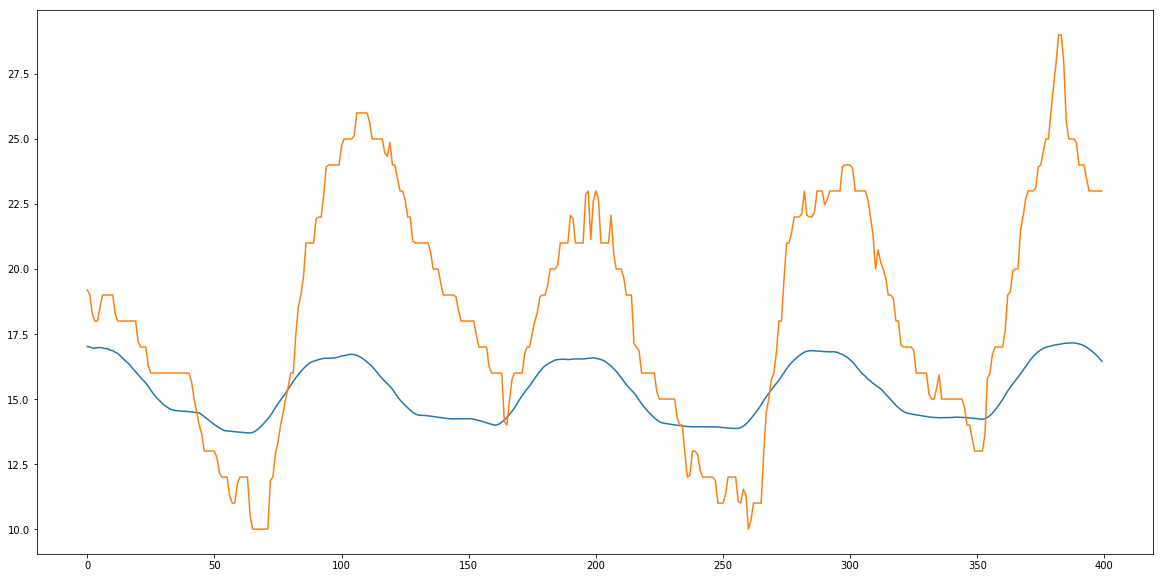

Saving...
Iter:  1 train:  0.16001202725336272 val:  0.109989116066578
Iter time:  0.5924702549818903
Saving...
Iter:  2 train:  0.0956604069334614 val:  0.06989683190268242
Iter time:  0.5817725849337876
Saving...
Iter:  3 train:  0.07374660931215399 val:  0.06898518880178332
Iter time:  0.5256415789481252
Saving...
Iter:  4 train:  0.06876789984030215 val:  0.06474522817329424
Iter time:  0.5104540960164741
Saving...
Iter:  5 train:  0.06552930364176716 val:  0.06092022595958467
Iter time:  0.5061229919083416
Saving...
Iter:  6 train:  0.060131864862682384 val:  0.058725050202740416
Iter time:  0.5068853120319545
Iter:  7 train:  0.05993358412951352 val:  0.06309579736761303
Iter time:  0.5104776960797608
Saving...
Iter:  8 train:  0.05710954844672827 val:  0.054910978797129854
Iter time:  0.5080439769662917
Saving...
Iter:  9 train:  0.05601782792114737 val:  0.05433086208042985
Iter time:  0.5079178030136973
Iter:  10 train:  0.05508695284225307 val:  0.05518791411356255
Iter time:

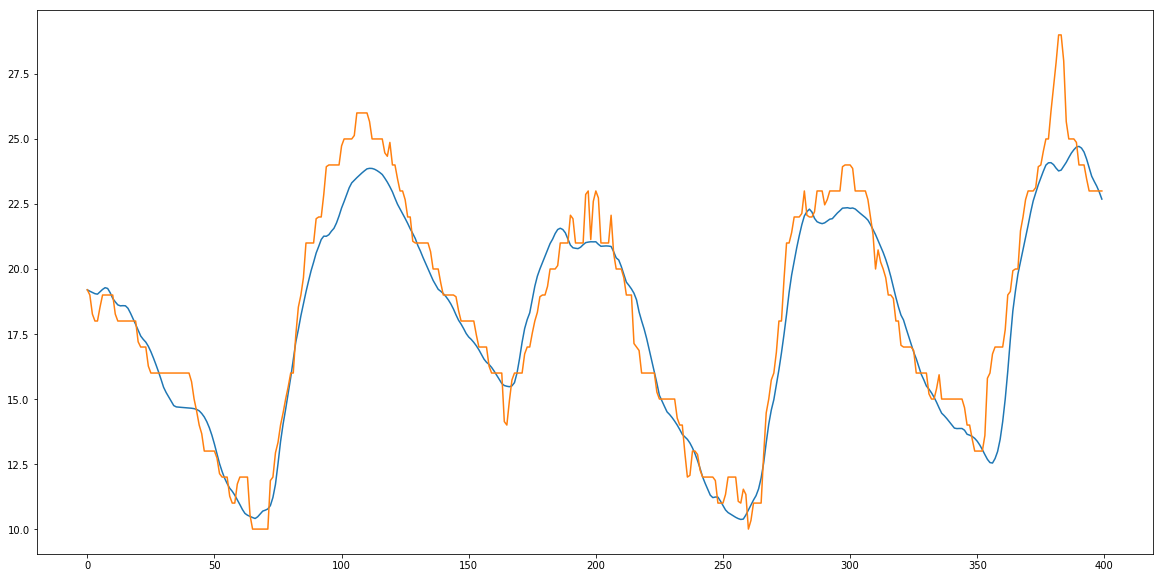

Iter:  11 train:  0.05430830738875859 val:  0.0575527827711598
Iter time:  0.5534310650546104
Iter:  12 train:  0.05546582038258756 val:  0.05600054498682969
Iter time:  0.8297934420406818
Iter:  13 train:  0.055480149407517956 val:  0.061940025878583056
Iter time:  0.6487942049279809
Saving...
Iter:  14 train:  0.05270412651967335 val:  0.05179065454107349
Iter time:  0.5858021579915658
Iter:  15 train:  0.05194661551385583 val:  0.053538530122338585
Iter time:  0.5526300569763407
Saving...
Iter:  16 train:  0.051185401956188765 val:  0.04999225731594566
Iter time:  0.5245612910948694
Iter:  17 train:  0.05026002718453275 val:  0.055755395580875916
Iter time:  0.5157583151012659
Iter:  18 train:  0.05091157464395556 val:  0.052482691378105725
Iter time:  0.5942281759344041
Saving...
Iter:  19 train:  0.04990293235728623 val:  0.04895351008657344
Iter time:  0.5978666000301018
Iter:  20 train:  0.04847280268350497 val:  0.049577491099930426
Iter time:  0.5344833570998162
mse:  1.189637

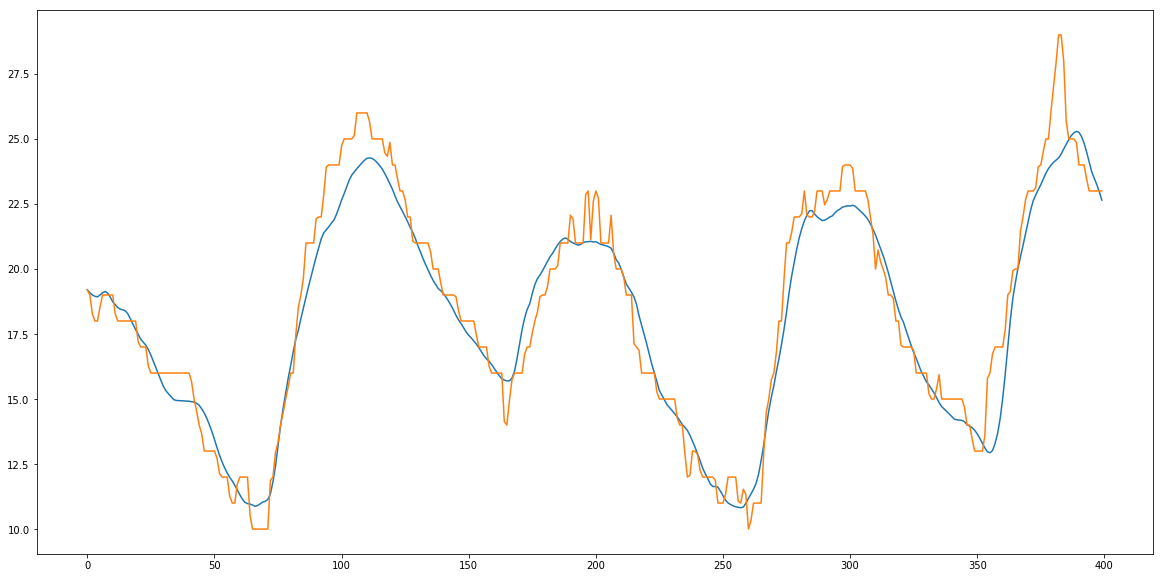

Saving...
Iter:  21 train:  0.04750058507668233 val:  0.04775000255909883
Iter time:  0.5150873869424686
Saving...
Iter:  22 train:  0.049986392059741154 val:  0.046234978293530536
Iter time:  0.5169550409773365
Iter:  23 train:  0.04601851335734379 val:  0.04699088236707918
Iter time:  0.5742479719920084
Iter:  24 train:  0.04622218200064915 val:  0.049525497144556035
Iter time:  0.5929506049724296
Iter:  25 train:  0.046040279407520764 val:  0.051290540659363386
Iter time:  0.5923297179397196
Saving...
Iter:  26 train:  0.044029920701673456 val:  0.044666186231667404
Iter time:  0.6459667489398271
Iter:  27 train:  0.04700581380315194 val:  0.05904070772566926
Iter time:  0.6287249829620123
Iter:  28 train:  0.04477696360317531 val:  0.045569947191406196
Iter time:  0.6479503250448033
Iter:  29 train:  0.043170812831567006 val:  0.04804164268722443
Iter time:  0.5994098669616506
Saving...
Iter:  30 train:  0.041610944802127535 val:  0.04329500661430304
Iter time:  0.5763212960446253


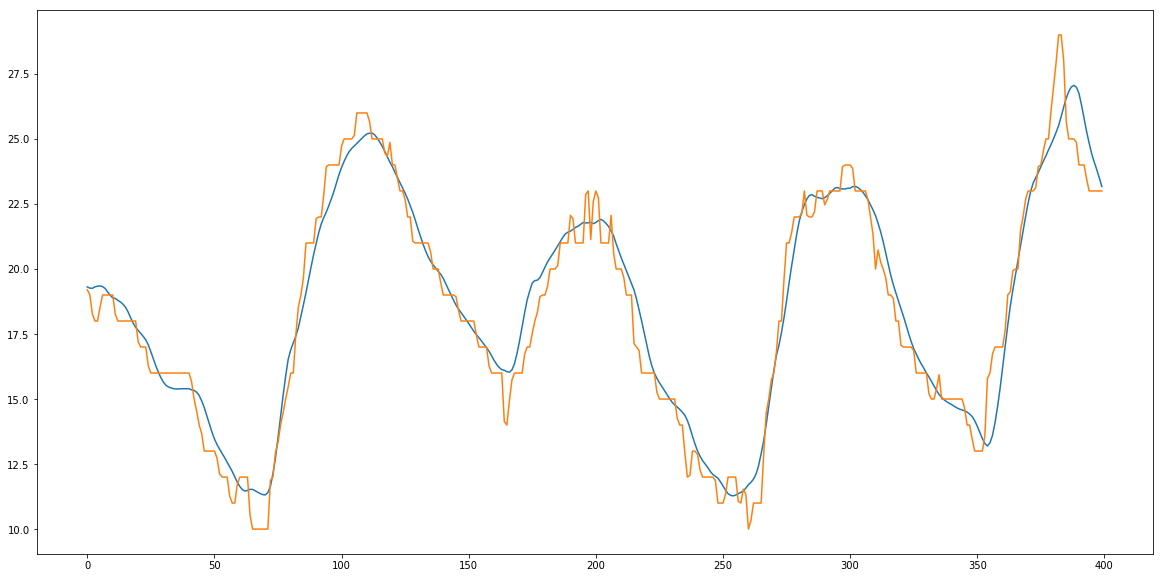

Saving...
Iter:  31 train:  0.0405156334403572 val:  0.041239503027004375
Iter time:  0.5347893070429564
Iter:  32 train:  0.04090771583358302 val:  0.044565788477413305
Iter time:  0.5487507689977065
Saving...
Iter:  33 train:  0.04099934929203217 val:  0.04086423591524755
Iter time:  0.5288770629558712
Iter:  34 train:  0.03972996690561644 val:  0.05342730243600995
Iter time:  0.5421872410224751
Iter:  35 train:  0.041893082428791 val:  0.04405108248117227
Iter time:  0.5493290679296479
Saving...
Iter:  36 train:  0.037550128890688636 val:  0.04075032764578081
Iter time:  0.5284942479338497
Saving...
Iter:  37 train:  0.036588946365791436 val:  0.039556325123622615
Iter time:  0.5214605489745736
Saving...
Iter:  38 train:  0.03892816271542866 val:  0.039470976152485154
Iter time:  0.5604149400023744
Iter:  39 train:  0.03644156619138802 val:  0.040180172566648076
Iter time:  0.5143552580848336
Iter:  40 train:  0.03678416997362005 val:  0.040730504439190046
Iter time:  0.515449931030

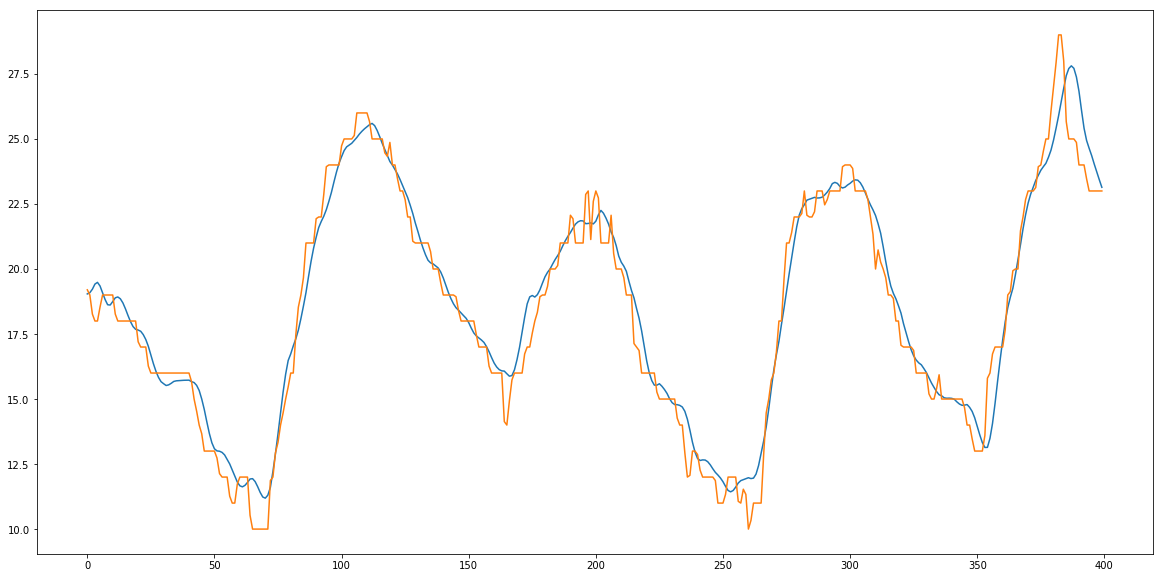

Iter:  41 train:  0.04005106674711525 val:  0.047521386288685935
Iter time:  0.5123993400484324
Saving...
Iter:  42 train:  0.036782452826385134 val:  0.03932817947041404
Iter time:  0.517274699988775
Iter:  43 train:  0.034996273609292916 val:  0.05030340660444381
Iter time:  0.513726438046433
Iter:  44 train:  0.036239140737904046 val:  0.039850396181683505
Iter time:  0.5131713279988617
Iter:  45 train:  0.03400068374084691 val:  0.03936508572360385
Iter time:  0.5148247900651768
Iter:  46 train:  0.03387973059184177 val:  0.039886597893662286
Iter time:  0.5138828449416906
Iter:  47 train:  0.03535878930998431 val:  0.050113581009554875
Iter time:  0.5199873660458252
Iter:  48 train:  0.03609612261962979 val:  0.04598738158585472
Iter time:  0.5140992699889466
Saving...
Iter:  49 train:  0.033321306041933174 val:  0.03912442258402663
Iter time:  0.5186305739916861
Saving...
Iter:  50 train:  0.034555749262465414 val:  0.037325642976281784
Iter time:  0.5192739539779723
mse:  0.6743

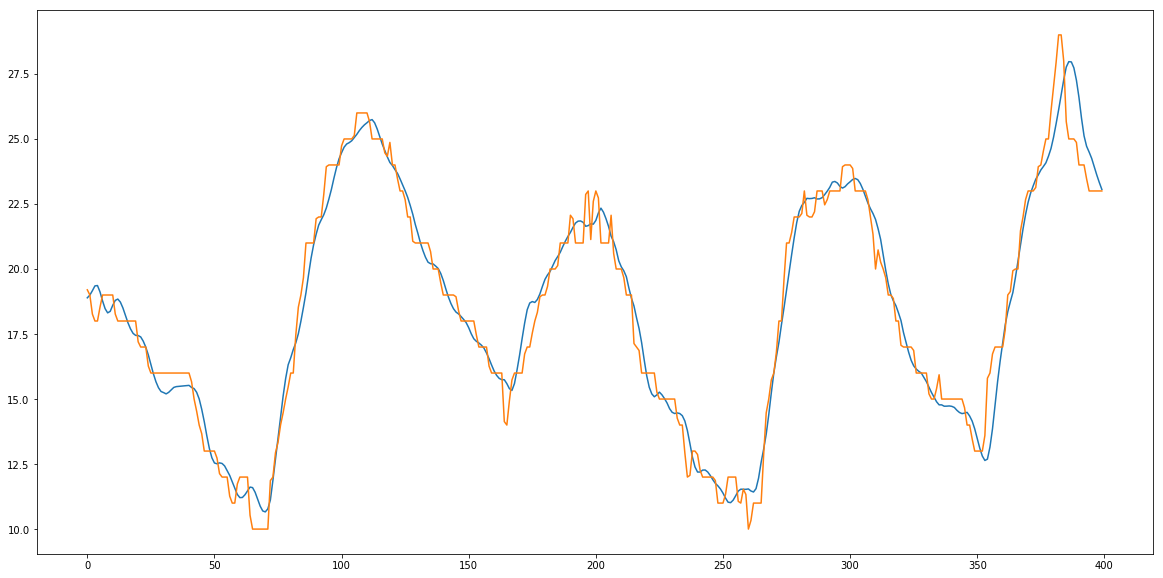

Iter:  51 train:  0.03336727552267956 val:  0.042559564114590276
Iter time:  0.5065066179959103
Iter:  52 train:  0.03583802752289219 val:  0.03754339960192579
Iter time:  0.5091287810355425
Saving...
Iter:  53 train:  0.03403383645780014 val:  0.036662460868475105
Iter time:  0.5683673610910773
Iter:  54 train:  0.0325599442077092 val:  0.03668179453159464
Iter time:  0.5205115529242903
Iter:  55 train:  0.03207984672595663 val:  0.03689555632710558
Iter time:  0.5298377809813246
Iter:  56 train:  0.032744440763835064 val:  0.037580734011674645
Iter time:  0.5333252559648827
Saving...
Iter:  57 train:  0.03536882933447596 val:  0.03593393883475682
Iter time:  0.5391381579684094
Iter:  58 train:  0.03148463969105898 val:  0.0408205917567872
Iter time:  0.5182836360763758
Iter:  59 train:  0.033214179437044244 val:  0.04376869972831577
Iter time:  0.508599465014413
Iter:  60 train:  0.0342065194684073 val:  0.0381631579433449
Iter time:  0.5268889450235292
mse:  0.7049103 mae:  0.641415

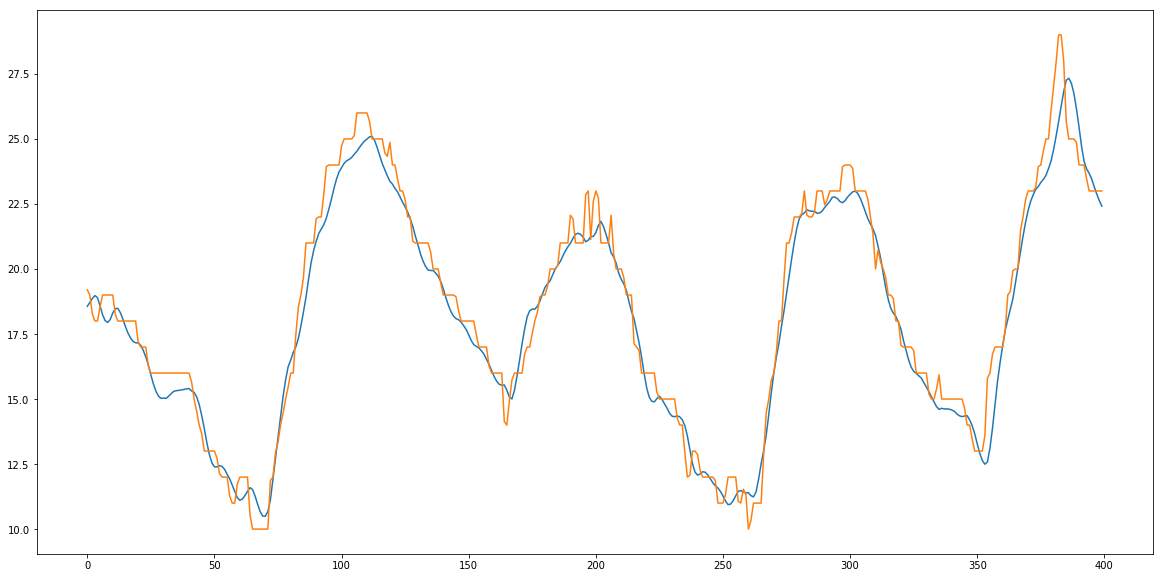

Iter:  61 train:  0.030807349880934837 val:  0.03650382096518917
Iter time:  0.5219788521062583
Saving...
Iter:  62 train:  0.030373602613805686 val:  0.035122286762624355
Iter time:  0.5419816630892456
Iter:  63 train:  0.029923724202292553 val:  0.03593682594289135
Iter time:  0.6225331129971892
Iter:  64 train:  0.029977694769871808 val:  0.03608453979890634
Iter time:  0.6318290960043669
Iter:  65 train:  0.03109500403339265 val:  0.03873111349195352
Iter time:  0.5667121669976041
Iter:  66 train:  0.02999915871101234 val:  0.03563329009902969
Iter time:  0.5109010300366208
Iter:  67 train:  0.03047144243898123 val:  0.03771573486934788
Iter time:  0.510735930991359
Saving...
Iter:  68 train:  0.029155571969829736 val:  0.03429247014297765
Iter time:  0.5191683530574664
Saving...
Iter:  69 train:  0.02907475891507671 val:  0.03391293932151754
Iter time:  0.5158602859592065
Iter:  70 train:  0.03351456711507038 val:  0.034392537038071144
Iter time:  0.5095134190050885
mse:  0.572497

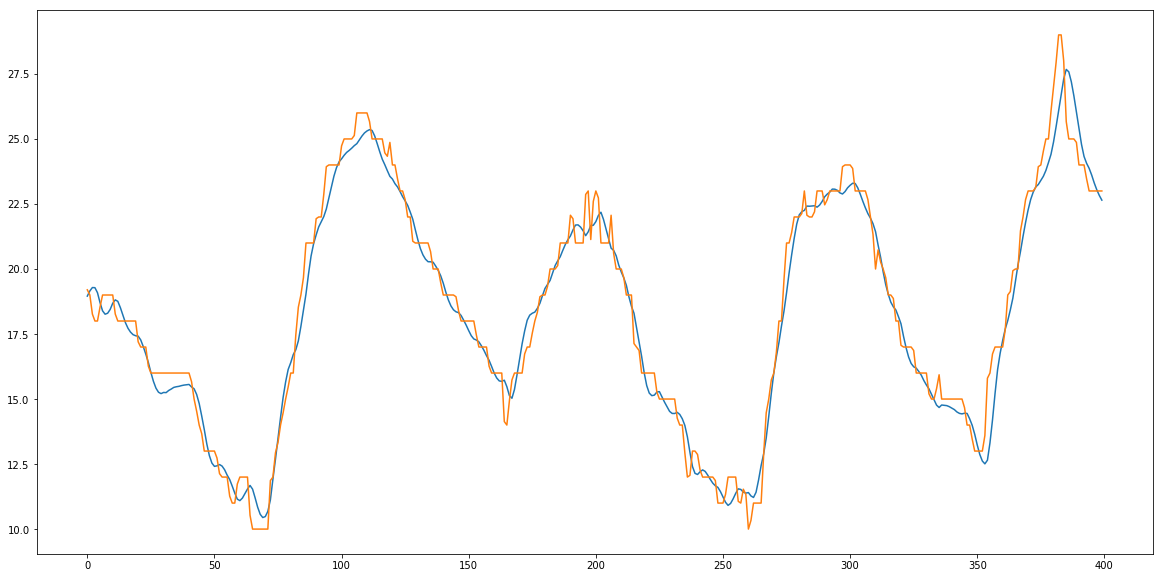

Iter:  71 train:  0.03194464837842328 val:  0.03407311090507099
Iter time:  0.510576004977338
Iter:  72 train:  0.034771105834075465 val:  0.03403193089694621
Iter time:  0.5114520950010046
Saving...
Iter:  73 train:  0.029213452761924302 val:  0.03382743795106861
Iter time:  0.5284737850306556
Iter:  74 train:  0.028963718612708054 val:  0.03454335665029378
Iter time:  0.5131055479869246
Iter:  75 train:  0.029586895205009154 val:  0.03797814275588455
Iter time:  0.5685035019414499
Iter:  76 train:  0.028863928567384522 val:  0.03481272764063018
Iter time:  0.6412903959862888
Iter:  77 train:  0.029939612344863736 val:  0.045686740872851295
Iter time:  0.6429326209472492
Saving...
Iter:  78 train:  0.031023767671638742 val:  0.033213569737361164
Iter time:  0.6134578560013324
Saving...
Iter:  79 train:  0.028831893815192935 val:  0.03306532975217254
Iter time:  0.5962439479772002
Iter:  80 train:  0.028101540201539883 val:  0.03430430175470545
Iter time:  0.6152444060426205
mse:  0.56

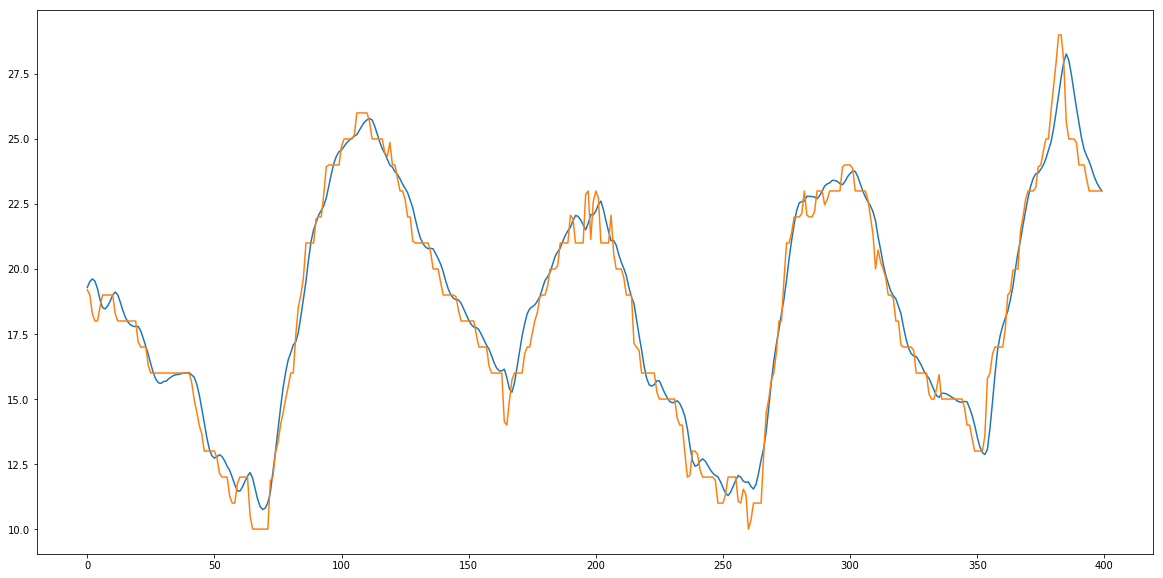

Iter:  81 train:  0.02848985475876366 val:  0.037829205540898865
Iter time:  0.5252928580157459
Saving...
Iter:  82 train:  0.03003757498297751 val:  0.0320290798812858
Iter time:  0.5194082070374861
Iter:  83 train:  0.028517452786018284 val:  0.032296528004866314
Iter time:  0.5109734949655831
Iter:  84 train:  0.027292254546474982 val:  0.03390464720695271
Iter time:  0.5115566159365699
Saving...
Iter:  85 train:  0.0275570934742485 val:  0.03162778679274246
Iter time:  0.5220642450731248
Iter:  86 train:  0.028753984148115384 val:  0.032822357411413726
Iter time:  0.5125243879156187
Iter:  87 train:  0.027360852835311554 val:  0.0349490779602278
Iter time:  0.515611145994626
Iter:  88 train:  0.02761918017795443 val:  0.03311479628376359
Iter time:  0.5169963799417019
Iter:  89 train:  0.03092073181171774 val:  0.03189996295843844
Iter time:  0.5117077910108492
Iter:  90 train:  0.027478900184354307 val:  0.03597714994201526
Iter time:  0.5137106559704989
mse:  0.62646794 mae:  0.6

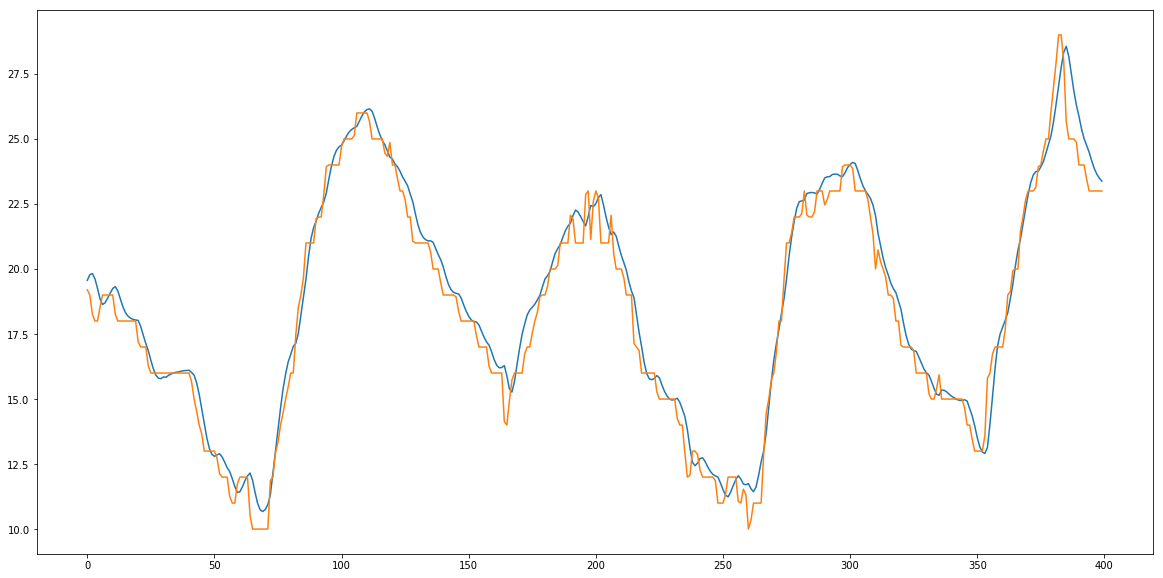

Saving...
Iter:  91 train:  0.026600130667924337 val:  0.030936913617193088
Iter time:  0.5265440749935806
Saving...
Iter:  92 train:  0.026742387188316896 val:  0.03084537061580785
Iter time:  0.5245234169997275
Iter:  93 train:  0.027687126267321043 val:  0.031130602104808364
Iter time:  0.5150954879354686
Iter:  94 train:  0.028968027189353505 val:  0.031525828661982364
Iter time:  0.5124574570218101
Iter:  95 train:  0.026409289236007952 val:  0.03295642475502883
Iter time:  0.514518492971547
Iter:  96 train:  0.026138255161345787 val:  0.03159764396411639
Iter time:  0.5135896750725806
Iter:  97 train:  0.02635490213328146 val:  0.03915529934451389
Iter time:  0.5121252540266141
Iter:  98 train:  0.030053120004704666 val:  0.03129813361624792
Iter time:  0.5124038510257378
Iter:  99 train:  0.027691043217168355 val:  0.033003964566641925
Iter time:  0.5129056089790538
Saving...
Iter:  100 train:  0.027690796608972865 val:  0.03078721019605185
Iter time:  0.5173271659296006
mse:  0

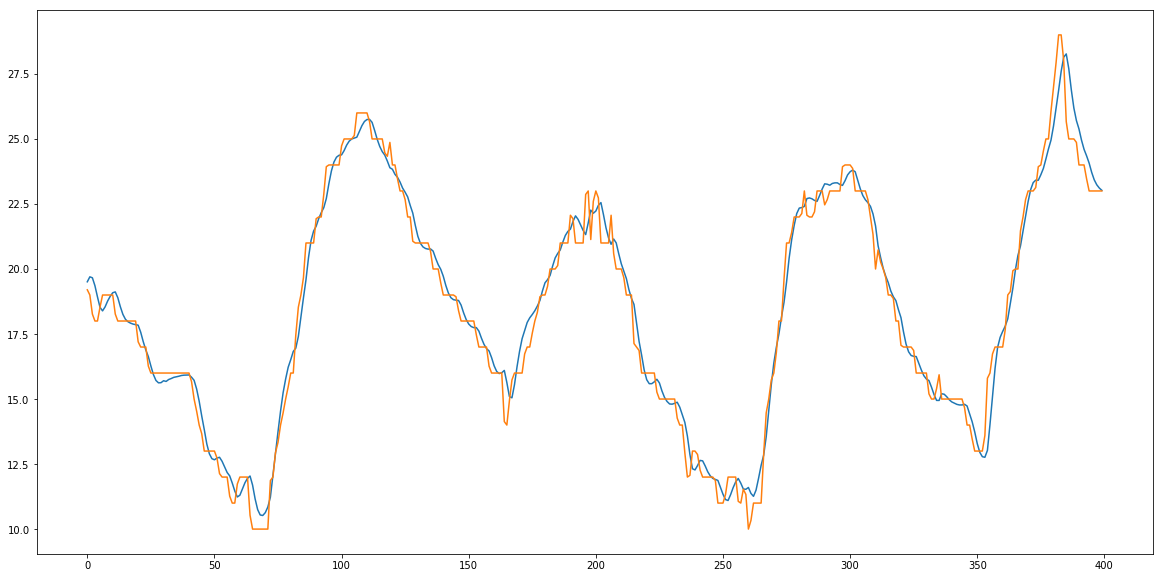

Saving...
Iter:  101 train:  0.025657674030342702 val:  0.03052107783277678
Iter time:  0.5217287390260026
Saving...
Iter:  102 train:  0.025884066491233267 val:  0.03015247342941324
Iter time:  0.5212028209352866
Iter:  103 train:  0.026453829131948138 val:  0.033479071760112326
Iter time:  0.6022008580621332
Iter:  104 train:  0.025192487097884943 val:  0.030157526599467053
Iter time:  0.5543025590013713
Iter:  105 train:  0.025133106362903352 val:  0.030360706583104635
Iter time:  0.6128610869636759
Iter:  106 train:  0.024402643816759953 val:  0.030334282458071748
Iter time:  0.643360628047958
Iter:  107 train:  0.024624410302045773 val:  0.032706791755111965
Iter time:  0.677787401014939
Saving...
Iter:  108 train:  0.025813514079251244 val:  0.029586883906772037
Iter time:  0.5983831840567291
Iter:  109 train:  0.024102123355990743 val:  0.030525931473937565
Iter time:  0.6288425329839811
Saving...
Iter:  110 train:  0.02482408089088262 val:  0.029275692275423152
Iter time:  0.62

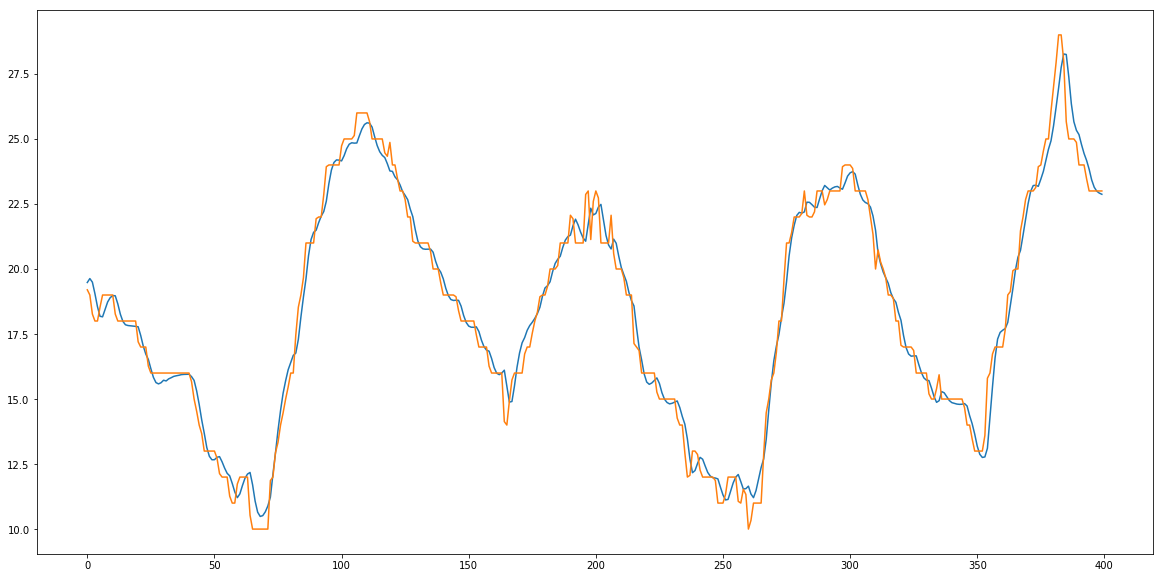

Iter:  111 train:  0.023985809729793636 val:  0.029909224307230947
Iter time:  0.6243746719555929
Iter:  112 train:  0.024210659199529586 val:  0.029344018199109374
Iter time:  0.5964422069955617
Saving...
Iter:  113 train:  0.0239372833059027 val:  0.02847149550068092
Iter time:  0.5809260330861434
Iter:  114 train:  0.02342574114768697 val:  0.029215683648677614
Iter time:  0.6337865020614117
Iter:  115 train:  0.023444790849886397 val:  0.02898232446984888
Iter time:  0.6177672649500892
Iter:  116 train:  0.024306099963359005 val:  0.02850237156256223
Iter time:  0.6236311719985679
Iter:  117 train:  0.024526756970602883 val:  0.03197863134096333
Iter time:  0.5828835970023647
Iter:  118 train:  0.02373322071552551 val:  0.028495973517495662
Iter time:  0.6239366150693968
Saving...
Iter:  119 train:  0.02374210954668806 val:  0.027964438147333633
Iter time:  0.6069848780753091
Saving...
Iter:  120 train:  0.022938142776018834 val:  0.027928440693055646
Iter time:  0.6263782969908789

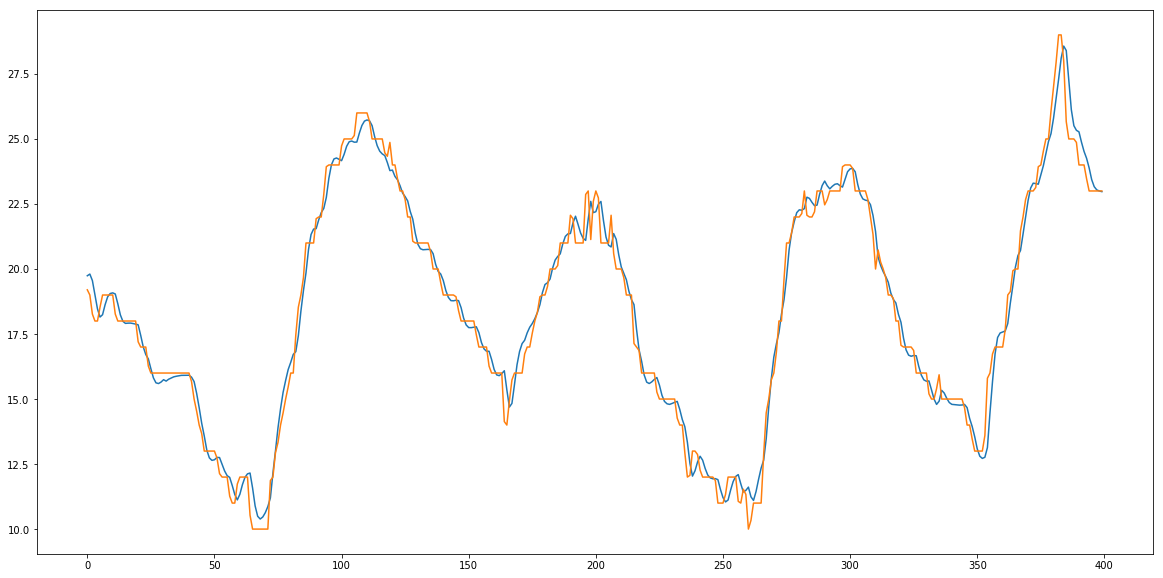

Saving...
Iter:  121 train:  0.025708132557897622 val:  0.027750708746826794
Iter time:  0.624297769041732
Iter:  122 train:  0.024462619987887298 val:  0.03244160129619393
Iter time:  0.6125857159495354
Iter:  123 train:  0.02497159864820648 val:  0.02788007270785464
Iter time:  0.5068266110029072
Iter:  124 train:  0.023860272105658914 val:  0.02897799800565548
Iter time:  0.5117688280297443
Iter:  125 train:  0.02317927924851727 val:  0.030696481982201276
Iter time:  0.5213468800066039
Saving...
Iter:  126 train:  0.022815119904099297 val:  0.02772148665645409
Iter time:  0.5115799710620195
Saving...
Iter:  127 train:  0.023927004937026496 val:  0.0274331942587185
Iter time:  0.5142360960599035
Iter:  128 train:  0.02322825642893809 val:  0.027591794505766955
Iter time:  0.5041766159702092
Saving...
Iter:  129 train:  0.02304502318175194 val:  0.027230089539309055
Iter time:  0.5093143050326034
Iter:  130 train:  0.02326215461779471 val:  0.03148303641983168
Iter time:  0.5048509340

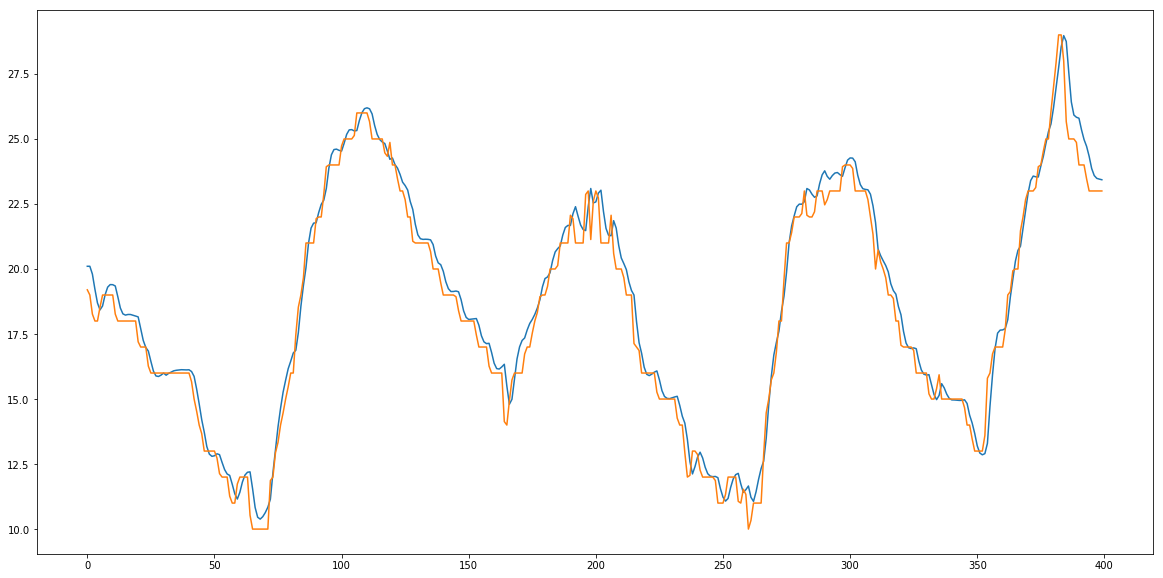

Iter:  131 train:  0.023370986506388976 val:  0.027956629726244315
Iter time:  0.5123409440275282
Iter:  132 train:  0.023024831605967234 val:  0.030359023538303415
Iter time:  0.5139028968987986
Iter:  133 train:  0.025020882522068244 val:  0.029032466935551032
Iter time:  0.525866177980788
Saving...
Iter:  134 train:  0.02240220005611867 val:  0.026943817812264202
Iter time:  0.5223406100412831
Iter:  135 train:  0.022947978897371133 val:  0.029220818979275736
Iter time:  0.5173081490211189
Iter:  136 train:  0.025854944608234037 val:  0.028142434915038837
Iter time:  0.5044069519499317
Iter:  137 train:  0.022902624825681256 val:  0.031196914824202716
Iter time:  0.510089070070535
Iter:  138 train:  0.022551169922555396 val:  0.027753869277478478
Iter time:  0.5068249079631642
Saving...
Iter:  139 train:  0.023730191684030958 val:  0.026640814272915758
Iter time:  0.5103880650131032
Iter:  140 train:  0.021974745510444493 val:  0.026950199548932678
Iter time:  0.5054827480344102
mse

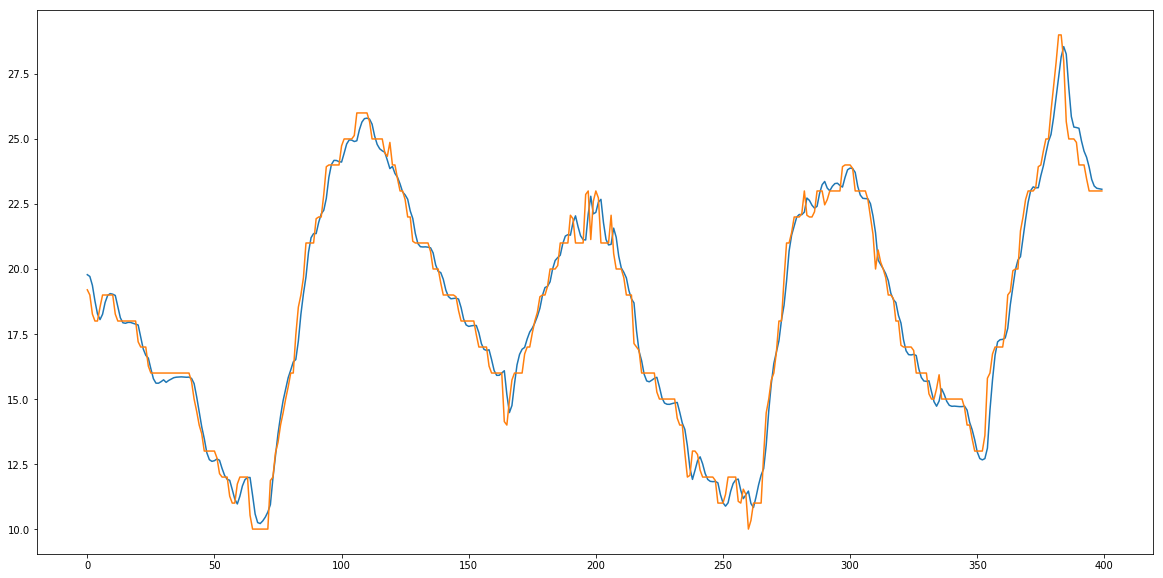

Iter:  141 train:  0.022337410951588095 val:  0.02812518576719605
Iter time:  0.5148821510374546
Saving...
Iter:  142 train:  0.0230150700231817 val:  0.026592379569577055
Iter time:  0.5501068379962817
Iter:  143 train:  0.021736767274315377 val:  0.026978544328696813
Iter time:  0.5290115920361131
Saving...
Iter:  144 train:  0.0216193699448516 val:  0.026522936879463117
Iter time:  0.5238087070174515
Iter:  145 train:  0.021690617976380475 val:  0.029321400549277246
Iter time:  0.5172851179959252
Iter:  146 train:  0.02277922249363217 val:  0.027154622385422284
Iter time:  0.5222231140360236
Iter:  147 train:  0.021957948491858673 val:  0.02680440921216491
Iter time:  0.5382898479001597
Iter:  148 train:  0.02281573069231159 val:  0.027568461741934055
Iter time:  0.5195624479092658
Iter:  149 train:  0.021907980828111264 val:  0.02907540999179434
Iter time:  0.5552674300270155
Saving...
Iter:  150 train:  0.02144493485861365 val:  0.025934993406621608
Iter time:  0.5427268989151344


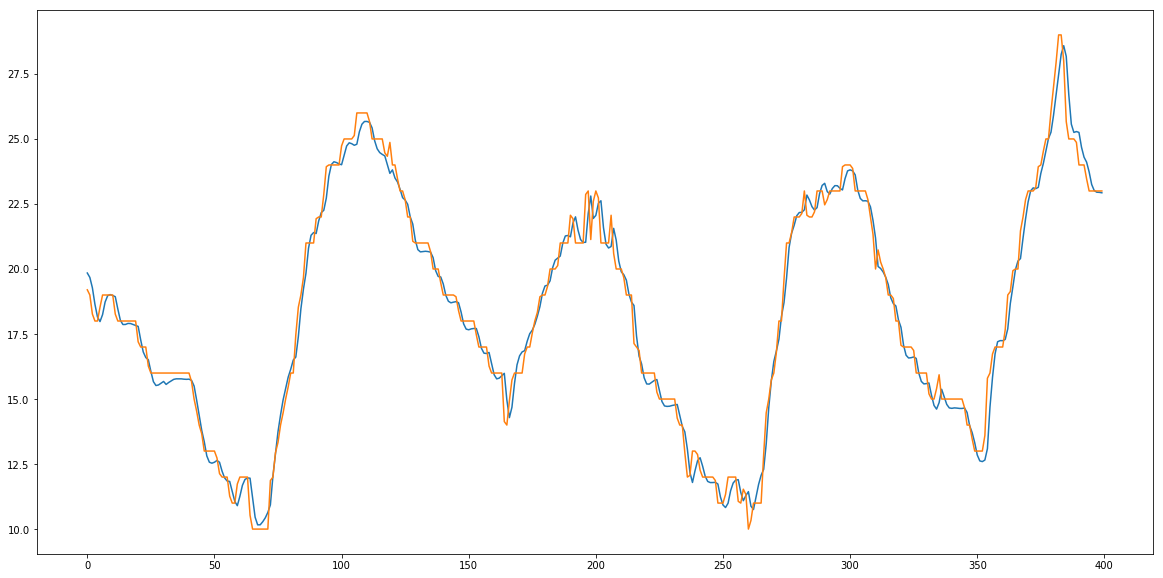

Saving...
Iter:  151 train:  0.021325915962946102 val:  0.025832755215085882
Iter time:  0.522870964021422
Saving...
Iter:  152 train:  0.02139423307768515 val:  0.025782624934119733
Iter time:  0.5298296010587364
Saving...
Iter:  153 train:  0.021654397820390834 val:  0.025658412199583435
Iter time:  0.5204636660637334
Iter:  154 train:  0.02129291285832417 val:  0.026028644454982097
Iter time:  0.5155797930201516
Iter:  155 train:  0.023226611868495776 val:  0.02927956228522083
Iter time:  0.5137352189049125
Iter:  156 train:  0.021918841547759516 val:  0.026266669716671964
Iter time:  0.5212185049895197
Saving...
Iter:  157 train:  0.021450513802997253 val:  0.02562357067709987
Iter time:  0.5195483380230144
Saving...
Iter:  158 train:  0.020825092598582652 val:  0.02554957721866877
Iter time:  0.5204367970582098
Iter:  159 train:  0.022577549379953488 val:  0.027625974345878834
Iter time:  0.5173579660477117
Iter:  160 train:  0.02124198946384025 val:  0.026331483721505067
Iter tim

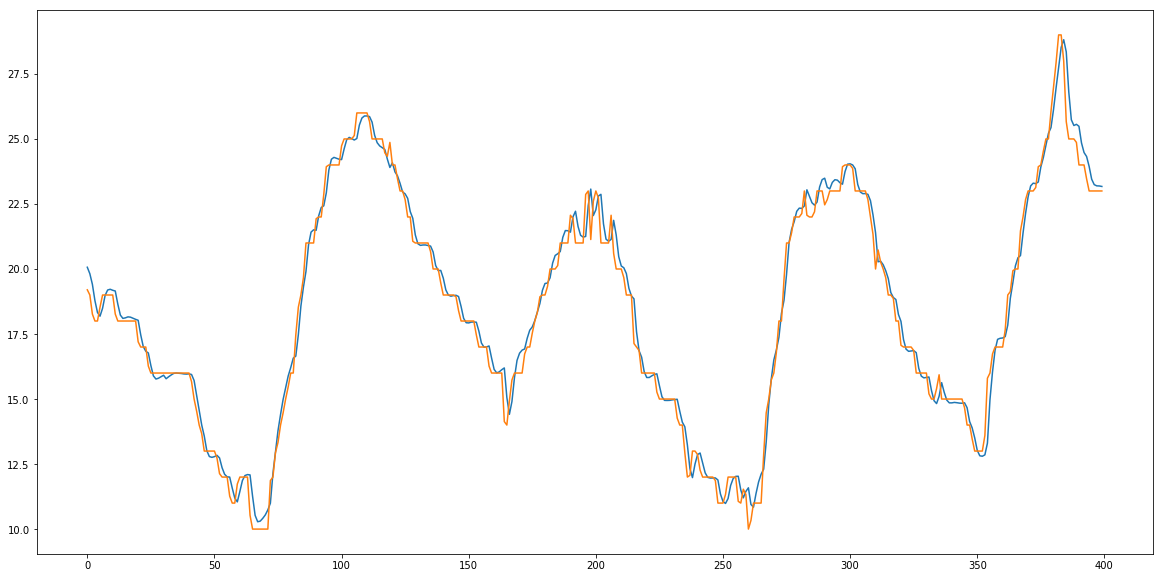

Iter:  161 train:  0.022091356310579457 val:  0.026344934892762205
Iter time:  0.5885638180188835
Iter:  162 train:  0.02119251754035354 val:  0.02620131114733602
Iter time:  0.5227308800676838
Saving...
Iter:  163 train:  0.020592432398187786 val:  0.025355168675357347
Iter time:  0.5383013399550691
Iter:  164 train:  0.020846733940836797 val:  0.025820111026497273
Iter time:  0.5161996110109612
Iter:  165 train:  0.021888764494085937 val:  0.02716526459393453
Iter time:  0.5139281980227679
Iter:  166 train:  0.023443031953420193 val:  0.028328670715276966
Iter time:  0.5683130300603807
Saving...
Iter:  167 train:  0.02259516760824664 val:  0.025335244616139375
Iter time:  0.5599174309754744
Saving...
Iter:  168 train:  0.02070203343141019 val:  0.02527976243619672
Iter time:  0.5262552630156279
Saving...
Iter:  169 train:  0.020357781329871566 val:  0.02502343869052971
Iter time:  0.5373655710136518
Iter:  170 train:  0.02039201646598235 val:  0.02573537918122342
Iter time:  0.516418

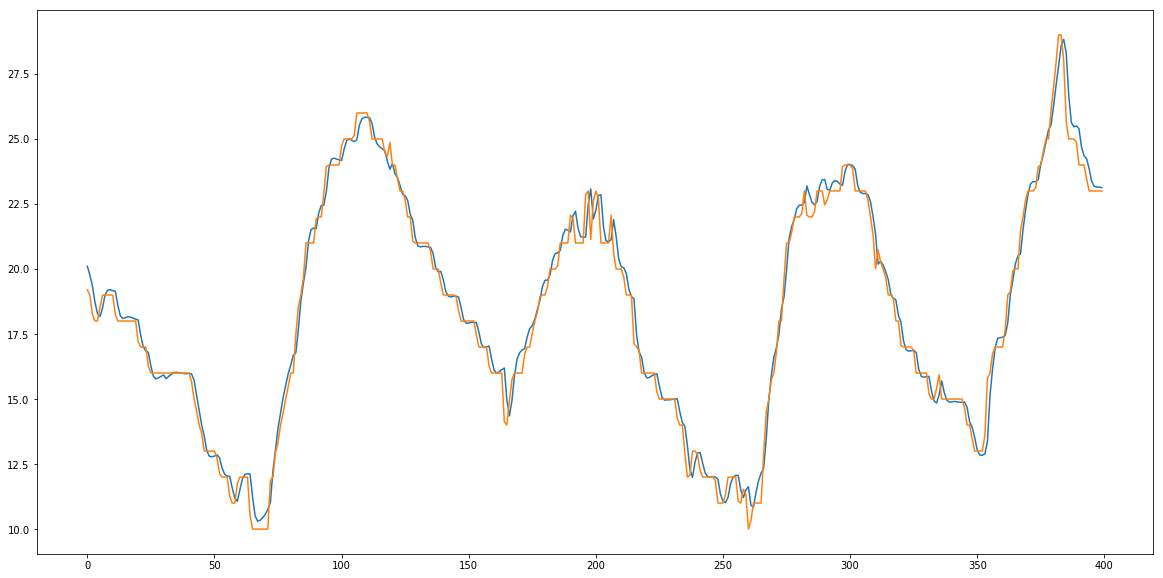

Saving...
Iter:  171 train:  0.02120605745103569 val:  0.024989983854420743
Iter time:  0.5300776249496266
Iter:  172 train:  0.020956374603014544 val:  0.028109890758599907
Iter time:  0.5275037199025974
Saving...
Iter:  173 train:  0.02145943952589884 val:  0.024789601811085582
Iter time:  0.5927468310110271
Iter:  174 train:  0.020362998416290266 val:  0.025255160905364466
Iter time:  0.5456280090147629
Iter:  175 train:  0.02013556936686797 val:  0.025368545358722454
Iter time:  0.5224856700515375
Iter:  176 train:  0.0205181558179052 val:  0.024945785553219375
Iter time:  0.5258221148978919
Iter:  177 train:  0.02143149882758551 val:  0.02500824661885086
Iter time:  0.5210640359437093
Saving...
Iter:  178 train:  0.020581518840788886 val:  0.024710775363075425
Iter time:  0.5549432460684329
Iter:  179 train:  0.01994350223022305 val:  0.02481444187681986
Iter time:  0.5768258839379996
Saving...
Iter:  180 train:  0.019850127169764153 val:  0.024424125314190987
Iter time:  0.605526

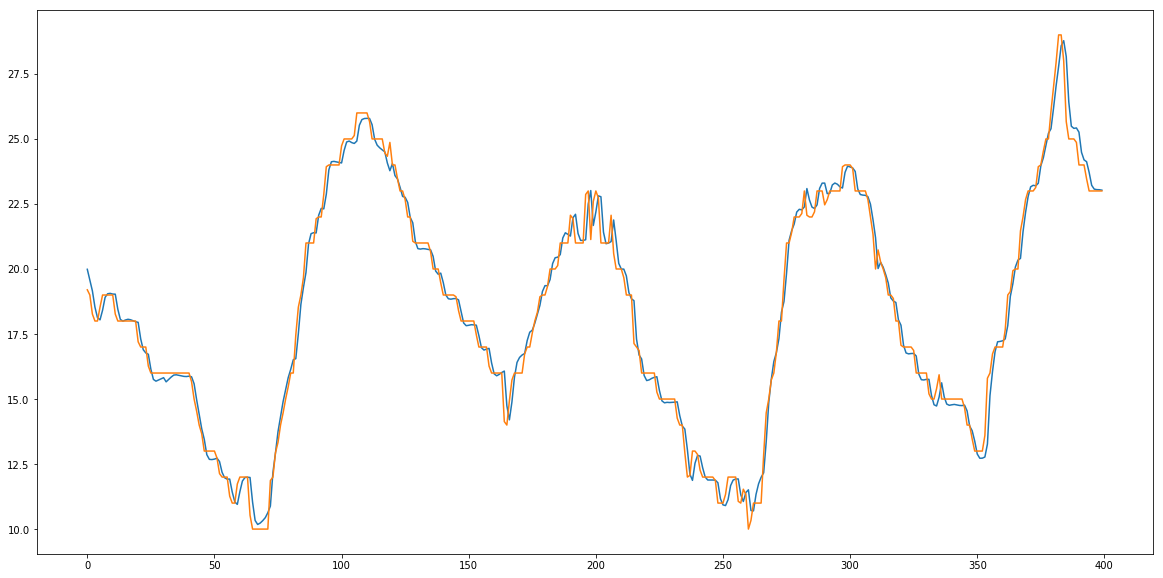

Iter:  181 train:  0.020118066940651186 val:  0.02535843606116706
Iter time:  0.6107260400895029
Iter:  182 train:  0.020331988706618884 val:  0.02600007722758896
Iter time:  0.6001769240247086
Saving...
Iter:  183 train:  0.02042627493892377 val:  0.024352525213509703
Iter time:  0.5298445300431922
Saving...
Iter:  184 train:  0.020056276773932607 val:  0.02424653539813088
Iter time:  0.5222219759598374
Saving...
Iter:  185 train:  0.020018186246603634 val:  0.024127738631968817
Iter time:  0.5176712239626795
Iter:  186 train:  0.02007849831889742 val:  0.024246932559885935
Iter time:  0.5147801809944212
Iter:  187 train:  0.019961390469915293 val:  0.02423696236937559
Iter time:  0.5190618899650872
Iter:  188 train:  0.01960806451800084 val:  0.024640658151499063
Iter time:  0.5122706759721041
Iter:  189 train:  0.01973248813165836 val:  0.026635339735646316
Iter time:  0.511750261997804
Iter:  190 train:  0.02301471464855552 val:  0.025529110204553954
Iter time:  0.5118160869460553


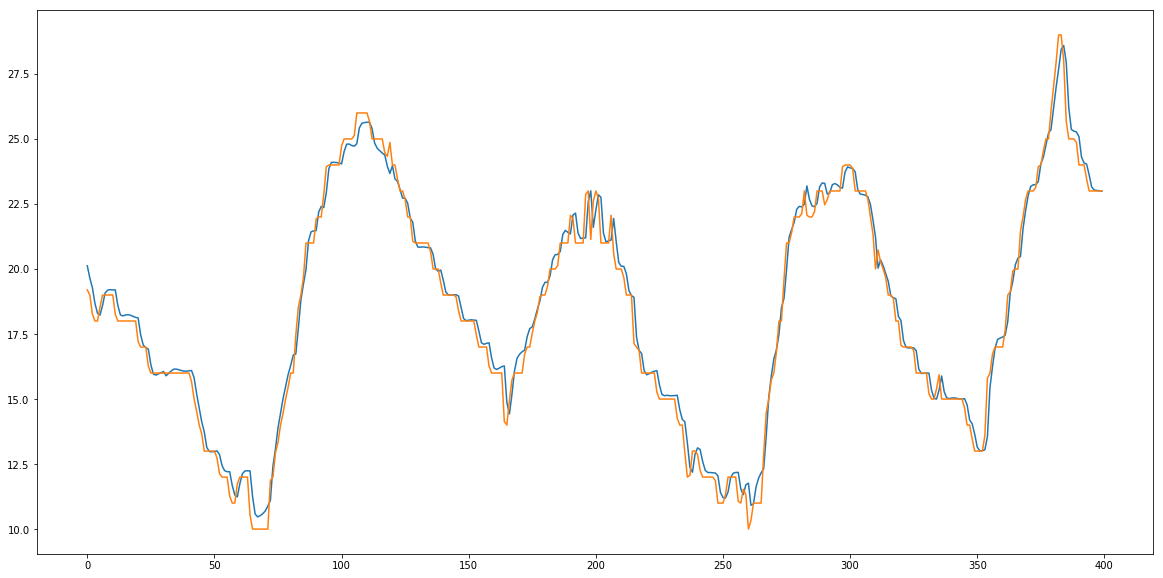

Iter:  191 train:  0.021210991194410358 val:  0.02679629065262955
Iter time:  0.5131955910474062
Iter:  192 train:  0.02026518014662036 val:  0.024656466715643522
Iter time:  0.5151581399841234
Saving...
Iter:  193 train:  0.019383047404366482 val:  0.023913488149366353
Iter time:  0.5189370330190286
Saving...
Iter:  194 train:  0.019608492260575476 val:  0.023908280862146306
Iter time:  0.5369755669962615
Iter:  195 train:  0.019076104648530164 val:  0.024151772321887973
Iter time:  0.699065905995667
Iter:  196 train:  0.02073886851483806 val:  0.02846097363148484
Iter time:  0.5217553849797696
Iter:  197 train:  0.022477140313467005 val:  0.02536411368518168
Iter time:  0.5613307749154046
Iter:  198 train:  0.021166110707616443 val:  0.024927116301795456
Iter time:  0.6597863499773666
Iter:  199 train:  0.020294251959841594 val:  0.024403653357692942
Iter time:  0.5714570039417595
Iter:  200 train:  0.019977946516800286 val:  0.025304378141795245
Iter time:  0.6105426590656862
mse:  

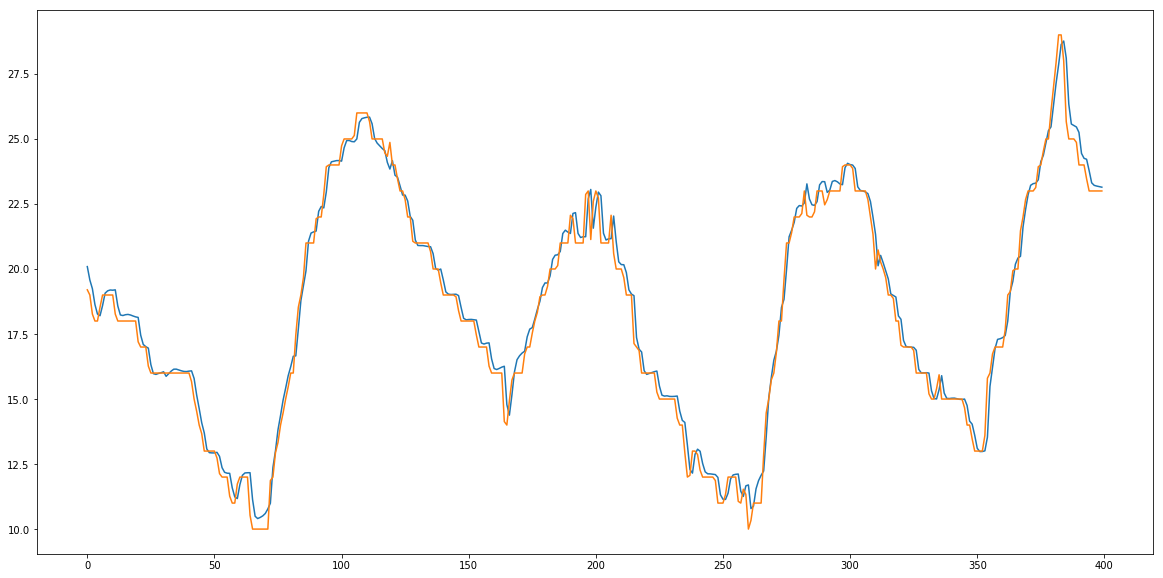

Saving...
Iter:  201 train:  0.01913259079709819 val:  0.02378275207780396
Iter time:  0.6744796970160678
Saving...
Iter:  202 train:  0.019188415369800742 val:  0.023757875573508256
Iter time:  0.6210879469290376
Saving...
Iter:  203 train:  0.019507069314537193 val:  0.023629347590554607
Iter time:  0.6155822799773887
Iter:  204 train:  0.01902800386943707 val:  0.026393861744425862
Iter time:  0.5845752679742873
Iter:  205 train:  0.01925118545452935 val:  0.024354890450936247
Iter time:  0.6108298189938068
Iter:  206 train:  0.019397277771243535 val:  0.02722742417797226
Iter time:  0.5737155249807984
Iter:  207 train:  0.020547523375175805 val:  0.026097593741791002
Iter time:  0.5068028440000489
Iter:  208 train:  0.020451292257623953 val:  0.0240685700467941
Iter time:  0.5590585559839383
Saving...
Iter:  209 train:  0.01993304056966331 val:  0.02357830083770735
Iter time:  0.6130088899517432
Saving...
Iter:  210 train:  0.019290249223622925 val:  0.02351941743872906
Iter time: 

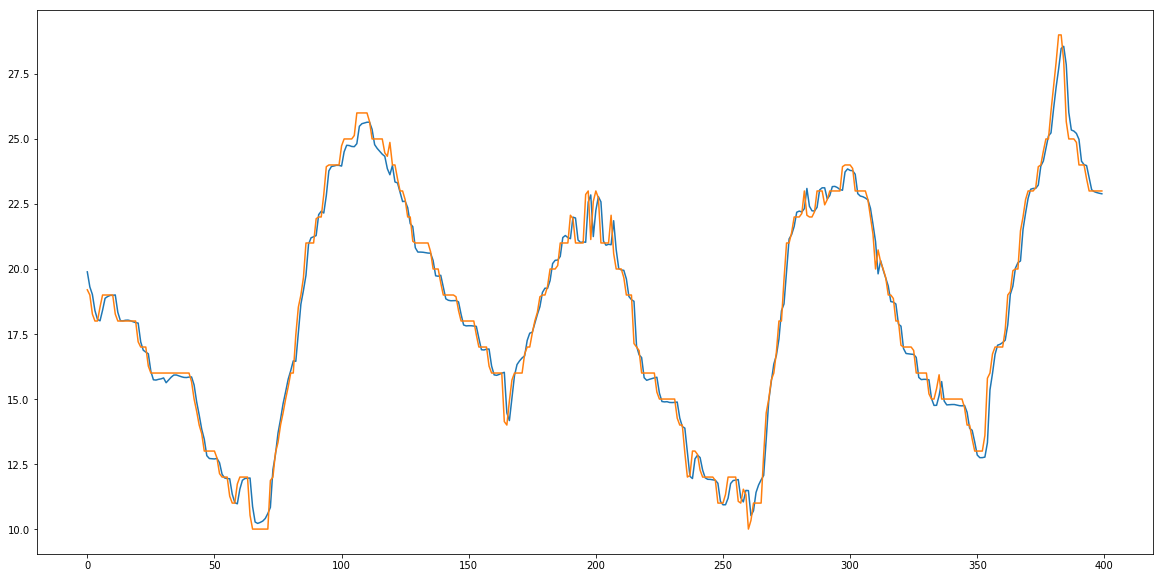

Iter:  211 train:  0.01910932988891305 val:  0.024979260669319735
Iter time:  0.6198450310621411
Iter:  212 train:  0.01950393319880701 val:  0.023701413934930957
Iter time:  0.5391681509790942
Iter:  213 train:  0.020044414908948652 val:  0.025905066843863157
Iter time:  0.5341602480039
Iter:  214 train:  0.01940472191284001 val:  0.025087827351654792
Iter time:  0.5248802420683205
Iter:  215 train:  0.02011278925143205 val:  0.02414139721308159
Iter time:  0.6212059090612456
Iter:  216 train:  0.019242714892741285 val:  0.023785574826488506
Iter time:  0.5917942969826981
Iter:  217 train:  0.01931533810926092 val:  0.02491841727780159
Iter time:  0.5949107740307227
Iter:  218 train:  0.019155817446831154 val:  0.025664899780094647
Iter time:  0.5933916759677231
Saving...
Iter:  219 train:  0.018653586681496956 val:  0.023251813810428623
Iter time:  0.580245511024259
Iter:  220 train:  0.018979459898618545 val:  0.023429740425923305
Iter time:  0.6419730499619618
mse:  0.26569304 mae:

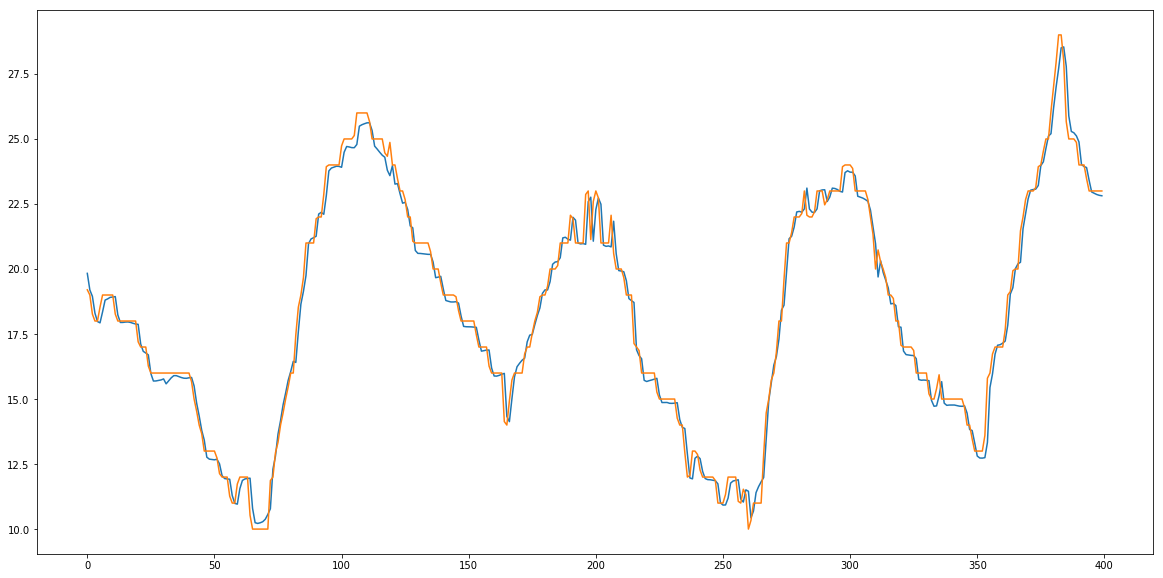

Iter:  221 train:  0.018712314447029404 val:  0.02442475008682945
Iter time:  0.5302750759292394
Iter:  222 train:  0.01922705129570299 val:  0.02384255594681277
Iter time:  0.5199725719867274
Iter:  223 train:  0.01902881558957606 val:  0.02448251511959644
Iter time:  0.5598191929748282
Iter:  224 train:  0.019530841475401375 val:  0.023341568130972788
Iter time:  0.610512075945735
Iter:  225 train:  0.018862703669987078 val:  0.024920293752588016
Iter time:  0.6011493490077555
Iter:  226 train:  0.018966906494297348 val:  0.02405858715170008
Iter time:  0.6161739340750501
Iter:  227 train:  0.01899584703935746 val:  0.026486071645494765
Iter time:  0.6100159219931811
Iter:  228 train:  0.020325075249078988 val:  0.023293531030102163
Iter time:  0.5204111229395494
Saving...
Iter:  229 train:  0.01887371096736954 val:  0.023135527336169935
Iter time:  0.5104164520744234
Saving...
Iter:  230 train:  0.01938126638369028 val:  0.02302027941791848
Iter time:  0.5088782469974831
mse:  0.256

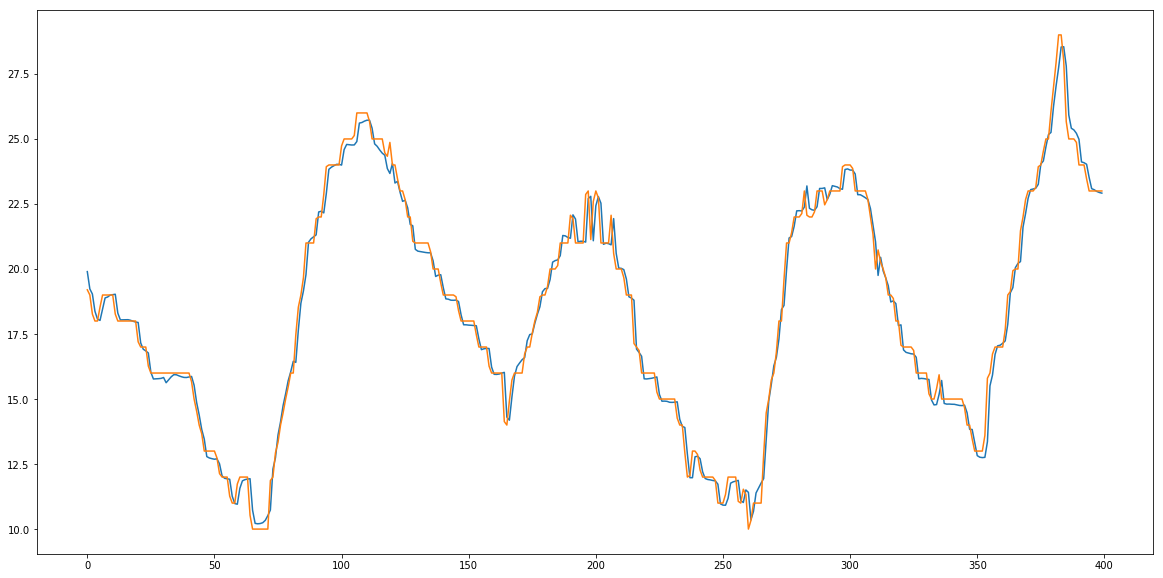

Iter:  231 train:  0.01848857984508513 val:  0.023954308591162075
Iter time:  0.5104817179962993
Iter:  232 train:  0.019390132770062376 val:  0.02311530148666045
Iter time:  0.5021387779852375
Iter:  233 train:  0.019022547721415352 val:  0.025345639486909814
Iter time:  0.5587637020507827
Iter:  234 train:  0.019283883947697554 val:  0.02321516989100624
Iter time:  0.524071542895399
Iter:  235 train:  0.020188854450890564 val:  0.02313033948451117
Iter time:  0.5480047080200166
Iter:  236 train:  0.018414990432098828 val:  0.023445818438150825
Iter time:  0.512917748070322
Iter:  237 train:  0.01907888733051321 val:  0.0231703041329389
Iter time:  0.579043984063901
Iter:  238 train:  0.018672484625977606 val:  0.023446554828961404
Iter time:  0.5395174749428406
Iter:  239 train:  0.01960350717442762 val:  0.02450407752584239
Iter time:  0.5192737799370661
Iter:  240 train:  0.018774871863236748 val:  0.02399435711042209
Iter time:  0.5190797430695966
mse:  0.27865285 mae:  0.3933404


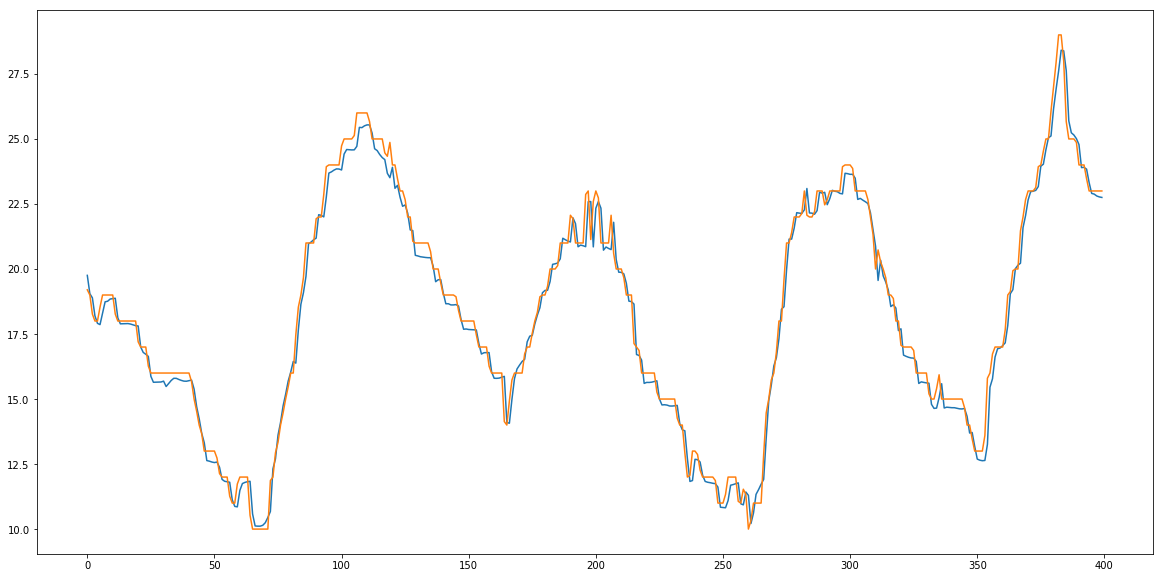

Saving...
Iter:  241 train:  0.01891522698997962 val:  0.0229834984363255
Iter time:  0.6232176809571683
Iter:  242 train:  0.019716453344125917 val:  0.02740508468056438
Iter time:  0.5969111690064892
Iter:  243 train:  0.01998120816378478 val:  0.0252180215235202
Iter time:  0.6166096930392087
Iter:  244 train:  0.018925582940293204 val:  0.023160427304401383
Iter time:  0.6106235620100051
Saving...
Iter:  245 train:  0.0189101914652869 val:  0.02291657794814204
Iter time:  0.6155964860226959
Iter:  246 train:  0.018226520400806488 val:  0.02306913698846419
Iter time:  0.6004249899415299
Iter:  247 train:  0.018318957512797808 val:  0.023660812558869097
Iter time:  0.6032094429247081
Iter:  248 train:  0.01860474714371812 val:  0.02388484791161218
Iter time:  0.5991323529742658
Iter:  249 train:  0.01867442125671589 val:  0.023875543537150455
Iter time:  0.5961622189497575
Iter:  250 train:  0.018394869396609614 val:  0.023381003394912964
Iter time:  0.6437569280387834
mse:  0.264588

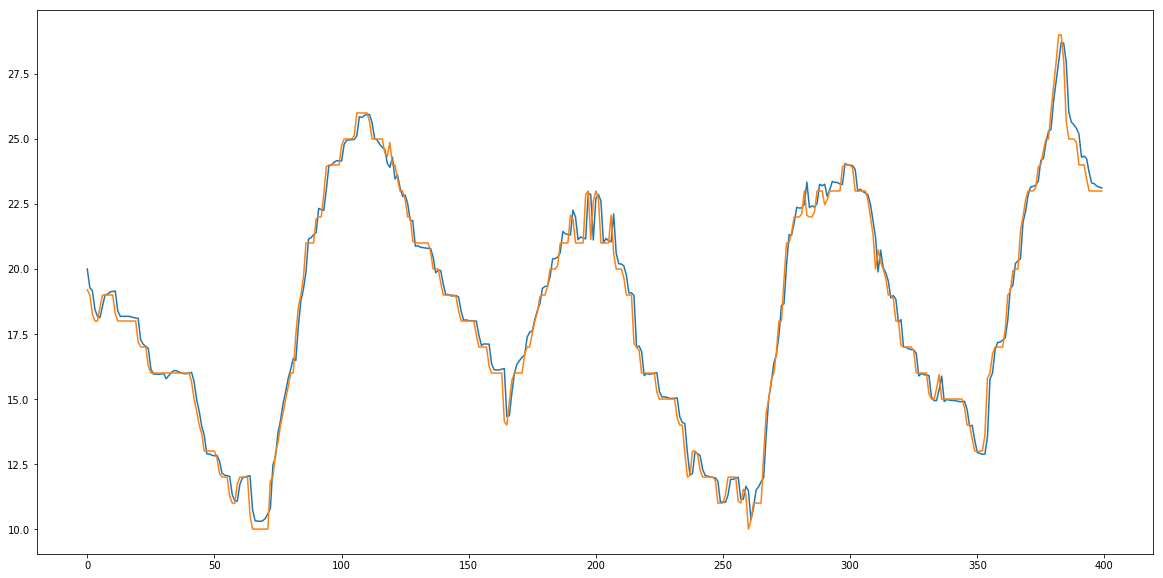

Iter:  251 train:  0.018461888744325687 val:  0.022961378122834917
Iter time:  0.6211598539957777
Iter:  252 train:  0.018367644615259436 val:  0.024424208154204135
Iter time:  0.6998499039327726
Saving...
Iter:  253 train:  0.018244473873847998 val:  0.02270565816692108
Iter time:  0.5803364539751783
Iter:  254 train:  0.018324829896752434 val:  0.023811292419092047
Iter time:  0.6018223760183901
Iter:  255 train:  0.018728772967051888 val:  0.023777899466074934
Iter time:  0.5112693589180708
Iter:  256 train:  0.018247709074083844 val:  0.023759733069523382
Iter time:  0.5109571419889107
Iter:  257 train:  0.0189307160425027 val:  0.022886195185438524
Iter time:  0.511556759942323
Saving...
Iter:  258 train:  0.017918367311325123 val:  0.022703272634933276
Iter time:  0.5166980709182099
Iter:  259 train:  0.018304765658139325 val:  0.02271505654424771
Iter time:  0.6054458650760353
Iter:  260 train:  0.019038496243297474 val:  0.02461793344837505
Iter time:  0.5314290979877114
mse:  

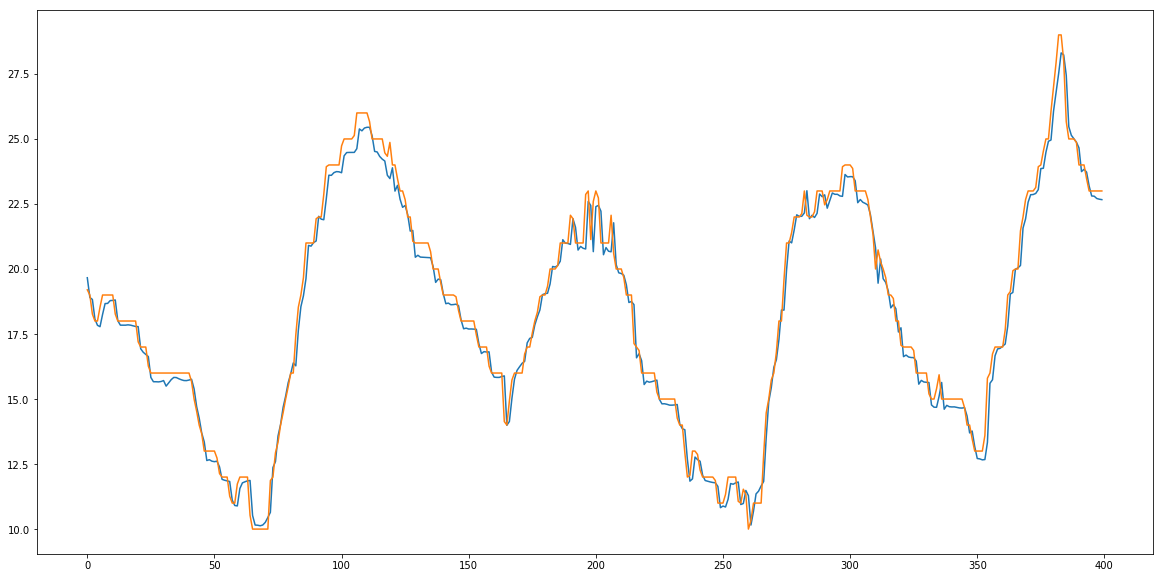

Iter:  261 train:  0.017982949527343764 val:  0.02270487498120727
Iter time:  0.5052465329645202
Iter:  262 train:  0.01841450457638829 val:  0.025050242794905586
Iter time:  0.516275633010082
Iter:  263 train:  0.01868376280745201 val:  0.024568255212148903
Iter time:  0.5190024649491534
Iter:  264 train:  0.01858020664007037 val:  0.02512767407650249
Iter time:  0.5165806929580867
Iter:  265 train:  0.01851705707186412 val:  0.023214495113546462
Iter time:  0.6726157299708575
Iter:  266 train:  0.018296442874271786 val:  0.02287695627140039
Iter time:  0.5615385900018737
Iter:  267 train:  0.01823480012945962 val:  0.02283555982520805
Iter time:  0.5902509089792147
Iter:  268 train:  0.018512610066957036 val:  0.023814472113537374
Iter time:  0.5827184389345348
Iter:  269 train:  0.018953173255187118 val:  0.02349286860720921
Iter time:  0.5190829259809107
Iter:  270 train:  0.01838539749556165 val:  0.023542945708476707
Iter time:  0.5071790469810367
mse:  0.2682668 mae:  0.3623378


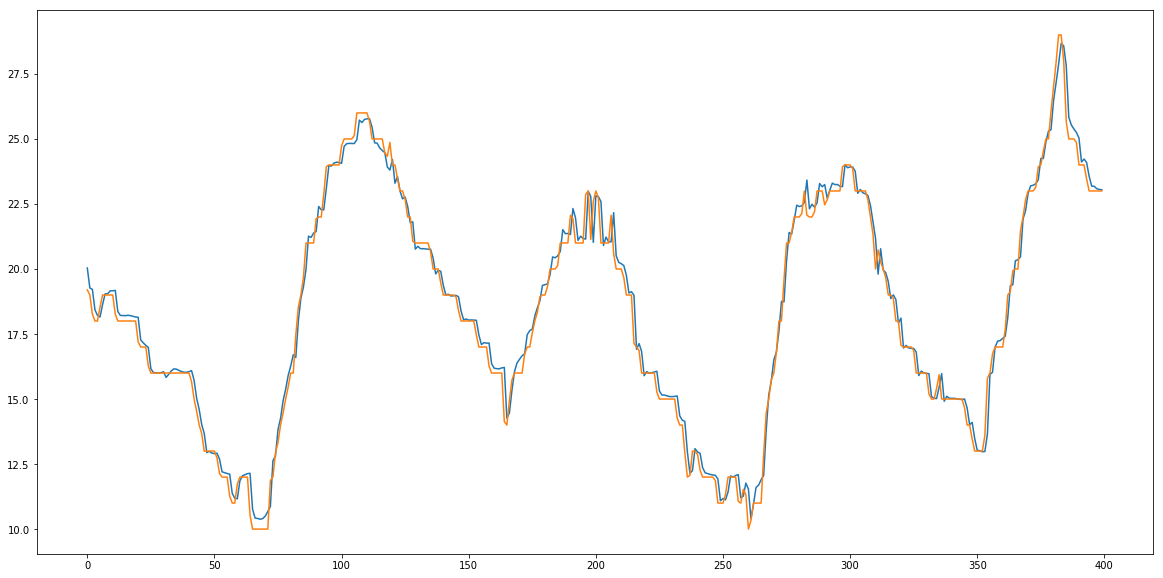

Iter:  271 train:  0.018665338160862764 val:  0.022883470685843555
Iter time:  0.5328675080090761
Iter:  272 train:  0.018280346694085736 val:  0.022805265657807102
Iter time:  0.5193712300388142
Iter:  273 train:  0.01865627180389294 val:  0.022712528841842636
Iter time:  0.5561226040590554
Iter:  274 train:  0.018094847741171104 val:  0.022948392082097206
Iter time:  0.5585265699774027
Iter:  275 train:  0.018141291428513923 val:  0.023672573870864293
Iter time:  0.5152216949500144
Iter:  276 train:  0.018236746763700035 val:  0.023127353204546702
Iter time:  0.5097365010296926
Iter:  277 train:  0.017850573762828354 val:  0.022736565588418953
Iter time:  0.5220396789954975
Iter:  278 train:  0.017906194256562407 val:  0.023344430263324858
Iter time:  0.513665794976987
Saving...
Iter:  279 train:  0.01784161586978451 val:  0.022526893284948765
Iter time:  0.5139029499841854
Iter:  280 train:  0.017994773468934907 val:  0.023730993019796157
Iter time:  0.5171401799889281
mse:  0.27256

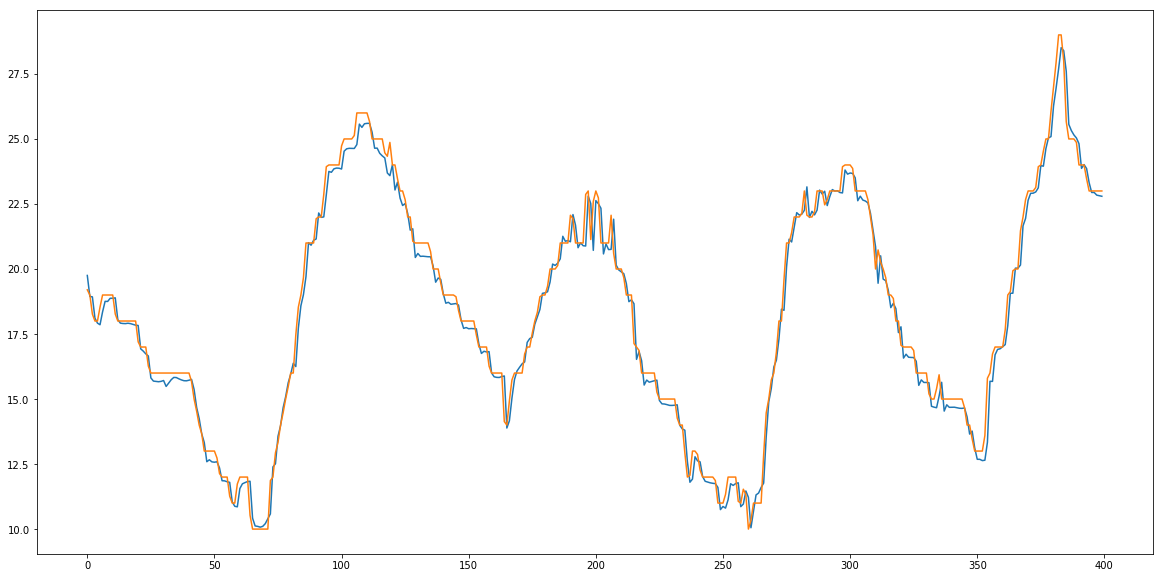

Iter:  281 train:  0.018211627895295755 val:  0.022678070412809677
Iter time:  0.5295798799488693
Iter:  282 train:  0.018662080312384078 val:  0.025441725276145723
Iter time:  0.5042261539492756
Iter:  283 train:  0.018042304587329226 val:  0.022551181017049556
Iter time:  0.5059894489822909
Iter:  284 train:  0.018688663891288423 val:  0.025802793586766393
Iter time:  0.5118051660247147
Iter:  285 train:  0.018663452511261242 val:  0.022746786448481507
Iter time:  0.5054004919948056
Iter:  286 train:  0.017911203155004895 val:  0.0237559713778764
Iter time:  0.513862430001609
Iter:  287 train:  0.01770101314709751 val:  0.022695671101689997
Iter time:  0.5156427080510184
Iter:  288 train:  0.017746355900692047 val:  0.023419657064526152
Iter time:  0.5131547329947352
Iter:  289 train:  0.01784847047359738 val:  0.022707685813053005
Iter time:  0.5117124189855531
Iter:  290 train:  0.017814703840425414 val:  0.022969999999056887
Iter time:  0.5128932860679924
mse:  0.25536847 mae:  0.

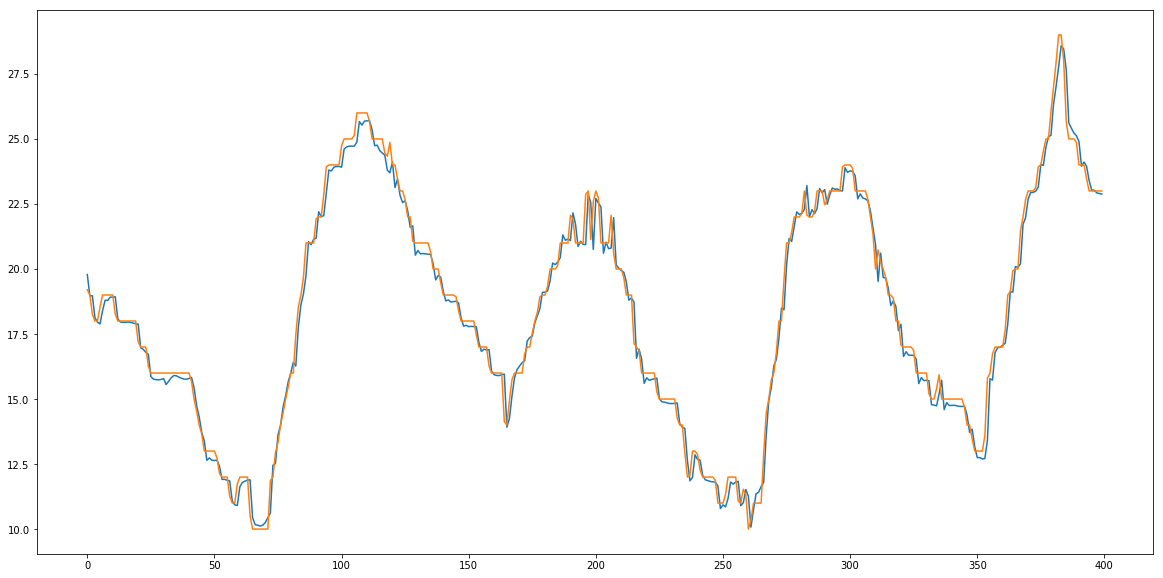

Iter:  291 train:  0.01788038878085813 val:  0.023249113579597462
Iter time:  0.5332735239062458
Iter:  292 train:  0.01792741092890582 val:  0.02270912944376296
Iter time:  0.5324367220746353
Iter:  293 train:  0.018285672685611296 val:  0.024959219047332126
Iter time:  0.5287338549969718
Iter:  294 train:  0.01811874578203093 val:  0.022642374002896724
Iter time:  0.518092320067808
Iter:  295 train:  0.017679361182300814 val:  0.0225891502893334
Iter time:  0.5215818489668891
Iter:  296 train:  0.01818244194143488 val:  0.02588484192199907
Iter time:  0.518693835940212
Iter:  297 train:  0.01782978487427547 val:  0.022563059063507574
Iter time:  0.518669243901968
Iter:  298 train:  0.018360502651834386 val:  0.022840223800487888
Iter time:  0.5283401580527425
Iter:  299 train:  0.017906131182241908 val:  0.022694470275871324
Iter time:  0.5275581510504708
Iter:  300 train:  0.017674966551183023 val:  0.02267111504356993
Iter time:  0.5264216519426554
mse:  0.24876599 mae:  0.34014466

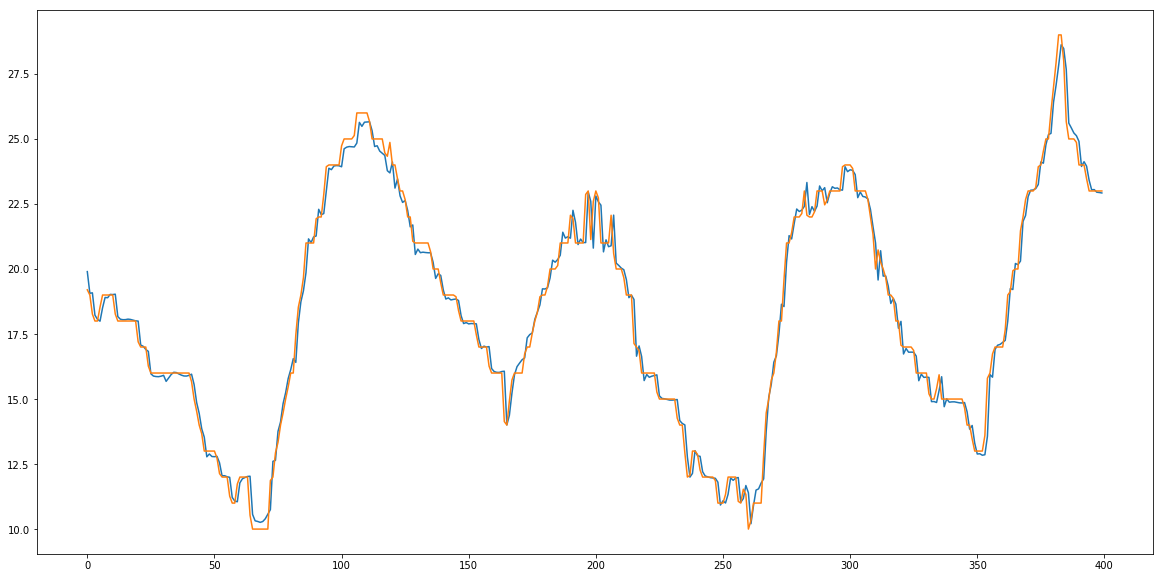

Iter:  301 train:  0.017709623587461462 val:  0.022679410290017687
Iter time:  0.5437987250043079
Iter:  302 train:  0.01794866992111099 val:  0.022849155466351606
Iter time:  0.5198581570293754
Iter:  303 train:  0.017958867225302648 val:  0.022794944619111943
Iter time:  0.5199837549589574
Iter:  304 train:  0.019155567868220195 val:  0.022758285823398797
Iter time:  0.5611347199883312
Iter:  305 train:  0.01840263235870858 val:  0.024316665014169368
Iter time:  0.6234204090433195
Iter:  306 train:  0.01832107680183919 val:  0.02326535234570138
Iter time:  0.6036715570371598
Iter:  307 train:  0.01797066296486099 val:  0.022842918395373064
Iter time:  0.5776674670632929
Iter:  308 train:  0.01754923212246904 val:  0.023140094277457137
Iter time:  0.5934036729158834
Iter:  309 train:  0.017662600095674604 val:  0.02271349878954228
Iter time:  0.5459902420407161
Iter:  310 train:  0.017876990472562138 val:  0.022627528149966658
Iter time:  0.5858216980705038
mse:  0.24781036 mae:  0.34

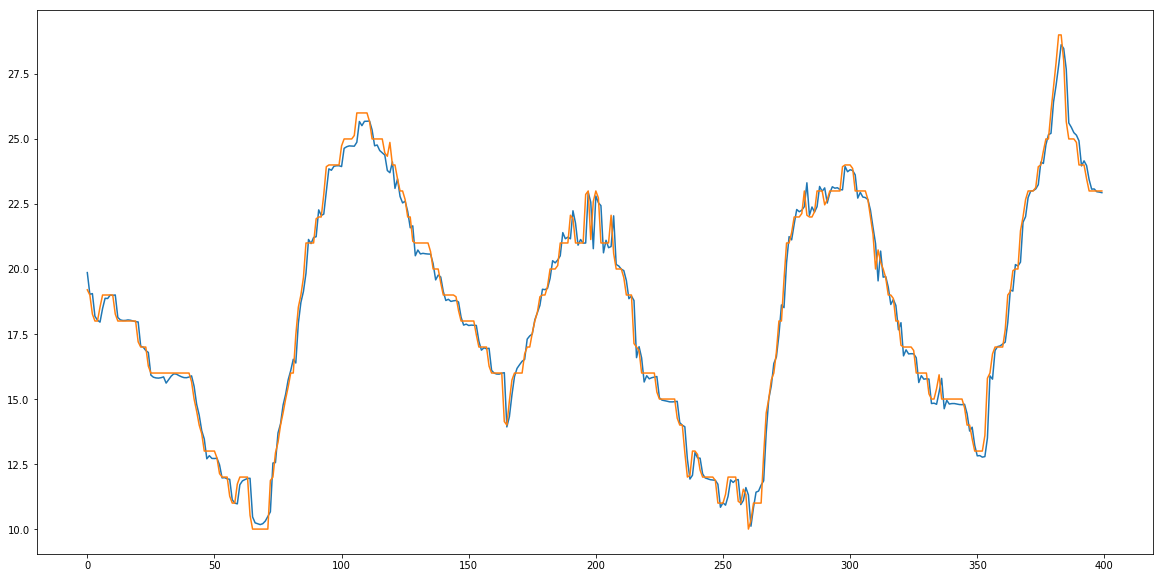

Iter:  311 train:  0.017684139704684857 val:  0.02265971482025655
Iter time:  0.5291444070171565
Iter:  312 train:  0.017725637272077575 val:  0.022745472957853275
Iter time:  0.5186807269928977
Iter:  313 train:  0.017810595259213198 val:  0.02268507409516556
Iter time:  0.5397398640634492


In [25]:
epochs = 1000
loss = nn.MSELoss()
patience = 35
min_val_loss = 9999
counter = 0
for i in range(epochs):
    mse_train = 0
    iteration_start = time.monotonic()
    for batch_x, batch_y in train_loader :
        batch_x = batch_x.cuda()
        batch_y = batch_y.cuda()
        opt.zero_grad()
        y_pred, alphas, betas = model(batch_x)
        y_pred = y_pred.squeeze(1)
        l = loss(y_pred, batch_y)
        l.backward()
        mse_train += l.item()*batch_x.shape[0]
        opt.step()
    epoch_scheduler.step()
    with torch.no_grad():
        mse_val = 0
        preds = []
        true = []
        for batch_x, batch_y in val_loader:
            batch_x = batch_x.cuda()
            batch_y = batch_y.cuda()
            output, alphas, betas = model(batch_x)
            output = output.squeeze(1)
            preds.append(output.detach().cpu().numpy())
            true.append(batch_y.detach().cpu().numpy())
            mse_val += loss(output, batch_y).item()*batch_x.shape[0]
    preds = np.concatenate(preds)
    true = np.concatenate(true)
    
    if min_val_loss > mse_val**0.5:
        min_val_loss = mse_val**0.5
        print("Saving...")
        torch.save(model.state_dict(), "imv_lstm_sml2010.pt")
        counter = 0
    else: 
        counter += 1
    
    if counter == patience:
        break
    print("Iter: ", i, "train: ", (mse_train/len(X_train_t))**0.5, "val: ", (mse_val/len(X_val_t))**0.5)
    iteration_end = time.monotonic()
    print("Iter time: ", iteration_end - iteration_start)
    if(i % 10 == 0):
        preds = preds*(y_train_max - y_train_min) + y_train_min
        true = true*(y_train_max - y_train_min) + y_train_min
        mse = mean_squared_error(true, preds)
        mae = mean_absolute_error(true, preds)
        print("mse: ", mse, "mae: ", mae)
        plt.figure(figsize=(20, 10))
        plt.plot(preds)
        plt.plot(true)
        plt.show()

In [26]:
model.load_state_dict(torch.load("imv_lstm_sml2010.pt"))

<All keys matched successfully>

In [27]:
with torch.no_grad():
    mse_val = 0
    preds = []
    true = []
    alphas = []
    betas = []
    for batch_x, batch_y in test_loader:
        batch_x = batch_x.cuda()
        batch_y = batch_y.cuda()
        output, a, b = model(batch_x)
        output = output.squeeze(1)
        preds.append(output.detach().cpu().numpy())
        true.append(batch_y.detach().cpu().numpy())
        alphas.append(a.detach().cpu().numpy())
        betas.append(b.detach().cpu().numpy())
        mse_val += loss(output, batch_y).item()*batch_x.shape[0]
preds = np.concatenate(preds)
true = np.concatenate(true)
alphas = np.concatenate(alphas)
betas = np.concatenate(betas)

In [28]:
preds = preds*(y_train_max - y_train_min) + y_train_min
true = true*(y_train_max - y_train_min) + y_train_min

In [29]:
mse = mean_squared_error(true, preds)
mae = mean_absolute_error(true, preds)

In [30]:
mse, mae

(0.15012735, 0.28722805)

In [31]:
mse**0.5

0.3874627095399338

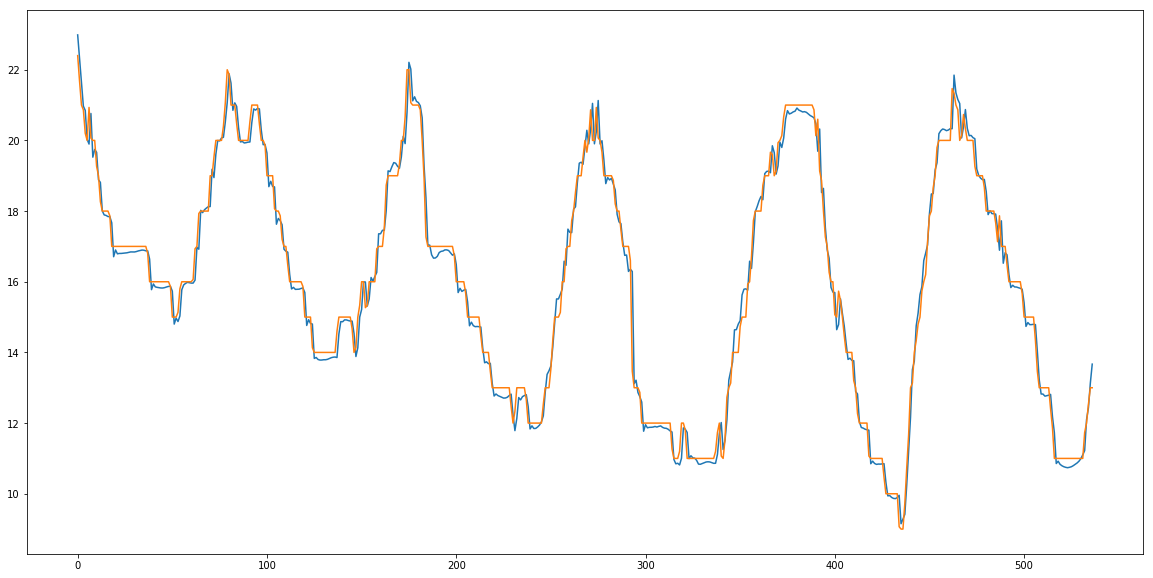

In [32]:
plt.figure(figsize=(20, 10))
plt.plot(preds)
plt.plot(true)
plt.show()

In [33]:
alphas.shape

(537, 10, 17, 1)

In [34]:
betas.shape

(537, 17, 1)

In [35]:
alphas = alphas.mean(axis=0)
betas = betas.mean(axis=0)

In [36]:
alphas = alphas[..., 0]
betas = betas[..., 0]

In [37]:
alphas = alphas.transpose(1, 0)

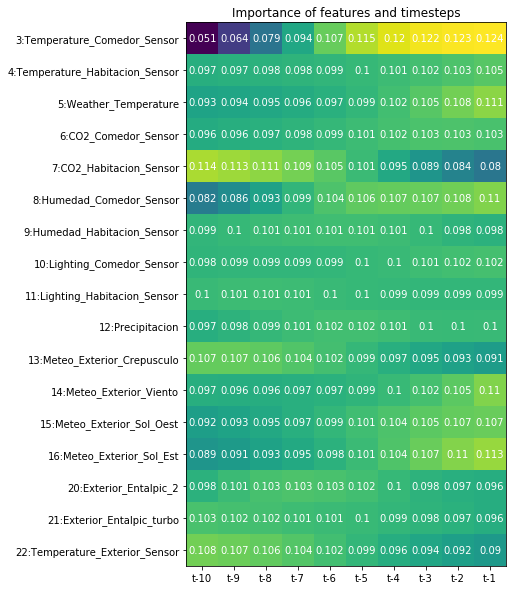

In [38]:
fig, ax = plt.subplots(figsize=(10, 10))
im = ax.imshow(alphas)
ax.set_xticks(np.arange(X_train_t.shape[1]))
ax.set_yticks(np.arange(len(cols)))
ax.set_xticklabels(["t-"+str(i) for i in np.arange(X_train_t.shape[1], -1, -1)])
ax.set_yticklabels(cols)
for i in range(len(cols)):
    for j in range(X_train_t.shape[1]):
        text = ax.text(j, i, round(alphas[i, j], 3),
                       ha="center", va="center", color="w")
ax.set_title("Importance of features and timesteps")
#fig.tight_layout()
plt.show()

([<matplotlib.axis.XTick at 0x7f4e502770f0>,
 <a list of 17 Text xticklabel objects>)

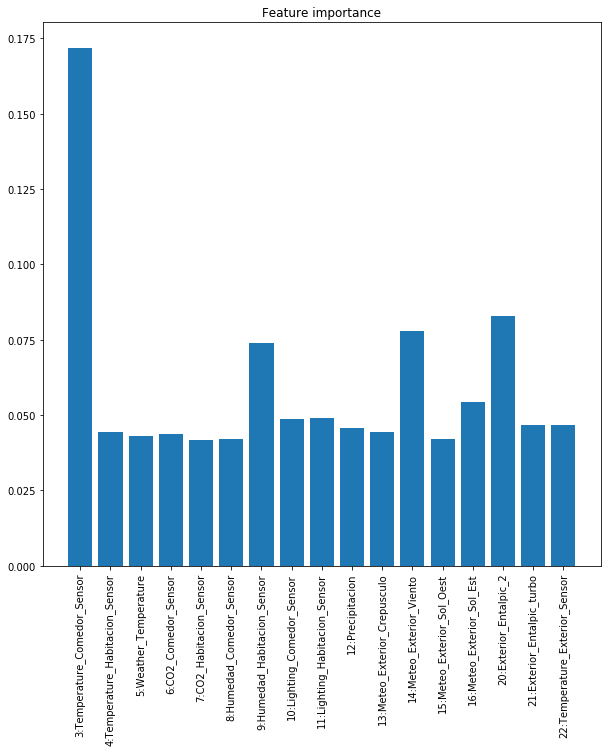

In [41]:
plt.figure(figsize=(10, 10))
plt.title("Feature importance")
plt.bar(range(len(cols)), betas)
plt.xticks(range(len(cols)), cols, rotation=90)